In [7]:
!pip install pyarrow


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [9]:
import numpy as np
import pandas as pd
import os
import sys
import pyarrow.parquet as pq
import re
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pytz
import math
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [10]:
def compute_portfolio_metrics(monthly_returns, hold_period):
    """

    Args:
    - returns (array-like): Array or list of portfolio returns

    Returns:
    - sharpe_ratio (float): Sharpe ratio of the portfolio
    - max_drawdown (float): Maximum drawdown of the portfolio
    - hit_rate (float): Hit rate of the portfolio (percentage of positive returns)
    """
    monthly_returns = monthly_returns/100
    # Calculate Sharpe Ratio
    annualized_returns = monthly_returns.mean() * 12/hold_period
    annualized_volatility = monthly_returns.std() * np.sqrt(12/hold_period)
    sharpe_ratio = annualized_returns / annualized_volatility

    # Maximum Drawdown
    cumulative_returns = (1 + monthly_returns).cumprod()
    peak_value = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak_value) / peak_value
    max_drawdown = drawdown.min()

    # Hit Rate
    positive_returns = monthly_returns[monthly_returns > 0]
    hit_rate = len(positive_returns) / len(monthly_returns)

    # Compound Annual Growth Rate (CAGR)
    total_return = cumulative_returns.iloc[-1] - 1
    num_years = len(monthly_returns)*hold_period/12
    cagr = ((1 + total_return) ** (1 / num_years) - 1)*100
    monthly_ret = int(monthly_returns.mean()*10000)
    monthly_vol = int(monthly_returns.std()*10000)

    metrics_dict = {
        'Sharpe Ratio': sharpe_ratio.round(2),
        'Max Drawdown': max_drawdown.round(2),
        'Hit Rate': str(int(hit_rate*100))+'%',
        'CAGR': str(cagr.round(2))+'%',
        'Monthly Returns': str(monthly_ret)+'bps' ,
        'Monthly Vol': str(monthly_vol)+'bps'
    }
    metrics_dict = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
    return metrics_dict

def plot_returns(monthly_returns, dates):
    """
    Plot monthly returns and cumulative returns.

    Parameters:
    - monthly_returns: Pandas Series or DataFrame with monthly portfolio returns.

    Returns:
    - None
    """
    monthly_returns = monthly_returns/100
    # Calculate cumulative returns
    cumulative_returns = (1 + monthly_returns).cumprod() - 1

    # Plot monthly returns
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(dates, monthly_returns, color='blue', label='Monthly Returns')
    plt.ylabel('Returns')
    plt.title('Monthly Returns')
    plt.yticks(color= 'red')

    # Plot cumulative returns
    plt.subplot(2, 1, 2)
    plt.plot(dates, cumulative_returns, color='green', label='Cumulative Returns')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns')

    plt.tight_layout()
    plt.show()
def plot_long_short_cumm_returns(long_ret, short_ret, dates, title = None):
    long_ret = long_ret/100
    short_ret = short_ret/100
    ret = long_ret - short_ret

    #long_cum_ret = (1 + long_ret).cumprod() - 1
    #short_cum_ret = (1 + short_ret).cumprod() - 1
    long_cum_ret = long_ret.cumsum()
    short_cum_ret = short_ret.cumsum()
    port_ret = ret.cumsum()
    #port_ret2 = long_cum_ret - short_cum_ret

    #Plot cumulative returns
    plt.figure(figsize=(20, 10))
    #plt.plot(dates, port_ret2, color='green', linestyle = ':', label='Cumulative Returns1')
    plt.plot(dates, port_ret, color = 'black', linestyle = '-', label = 'Cumulative Returns')
    plt.plot(dates, long_cum_ret, color = 'black', linestyle = 'dashed', label = 'Long Portfolio')
    plt.plot(dates, short_cum_ret, color = 'black', linestyle = '-.', label = 'Short Portfolio')
    plt.ylabel('Cumulative Returns')
    plt.title(f'Cumulative Returns {title}')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
def get_monthly_returns(port_returns, hold_period):
    port_returns = port_returns.copy(deep = True)
    # Find columns containing 'return' substring
    return_columns = [col for col in port_returns.columns if 'long_return' in col.lower() or 'short_return' in col.lower()]
    total_return_columns = set([col.replace('long_', '').replace('short_', '') for col in return_columns])
    #print(total_return_columns)
    for col in return_columns:
        #print(col)
        port_returns[col] = port_returns[col].apply(lambda x: ((1+x/100)**(1/hold_period) - 1)*100)
    for col in total_return_columns:
        port_returns[col] = port_returns['long_' + col] - port_returns['short_' + col]
    return port_returns

In [12]:
month_dict = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
folder_path = r'/data/workspace_files/parquet_files'

Running for hold_period: 1, lookback_period: 1, num_bucket: 5, score_type: cosine_similarity
Running for hold_period: 1, lookback_period: 1, num_bucket: 10, score_type: cosine_similarity
Running for hold_period: 1, lookback_period: 3, num_bucket: 5, score_type: cosine_similarity
Running for hold_period: 1, lookback_period: 3, num_bucket: 10, score_type: cosine_similarity
Running for hold_period: 1, lookback_period: 6, num_bucket: 5, score_type: cosine_similarity
Running for hold_period: 1, lookback_period: 6, num_bucket: 10, score_type: cosine_similarity
Running for hold_period: 3, lookback_period: 3, num_bucket: 5, score_type: cosine_similarity
Running for hold_period: 3, lookback_period: 3, num_bucket: 10, score_type: cosine_similarity
Running for hold_period: 3, lookback_period: 6, num_bucket: 5, score_type: cosine_similarity
Running for hold_period: 3, lookback_period: 6, num_bucket: 10, score_type: cosine_similarity
Running for hold_period: 6, lookback_period: 6, num_bucket: 5, sc

<ipython-input-10-754bee8c6be6>:31: RuntimeWarning: invalid value encountered in scalar power
  cagr = ((1 + total_return) ** (1 / num_years) - 1)*100


Value 
 
 
 
 
 Sharpe Ratio 
 1.27 
 
 
 Max Drawdown 
 -0.19 
 
 
 Hit Rate 
 67% 
 
 
 CAGR 
 10.9% 
 
 
 Monthly Returns 
 89bps 
 
 
 Monthly Vol 
 244bps

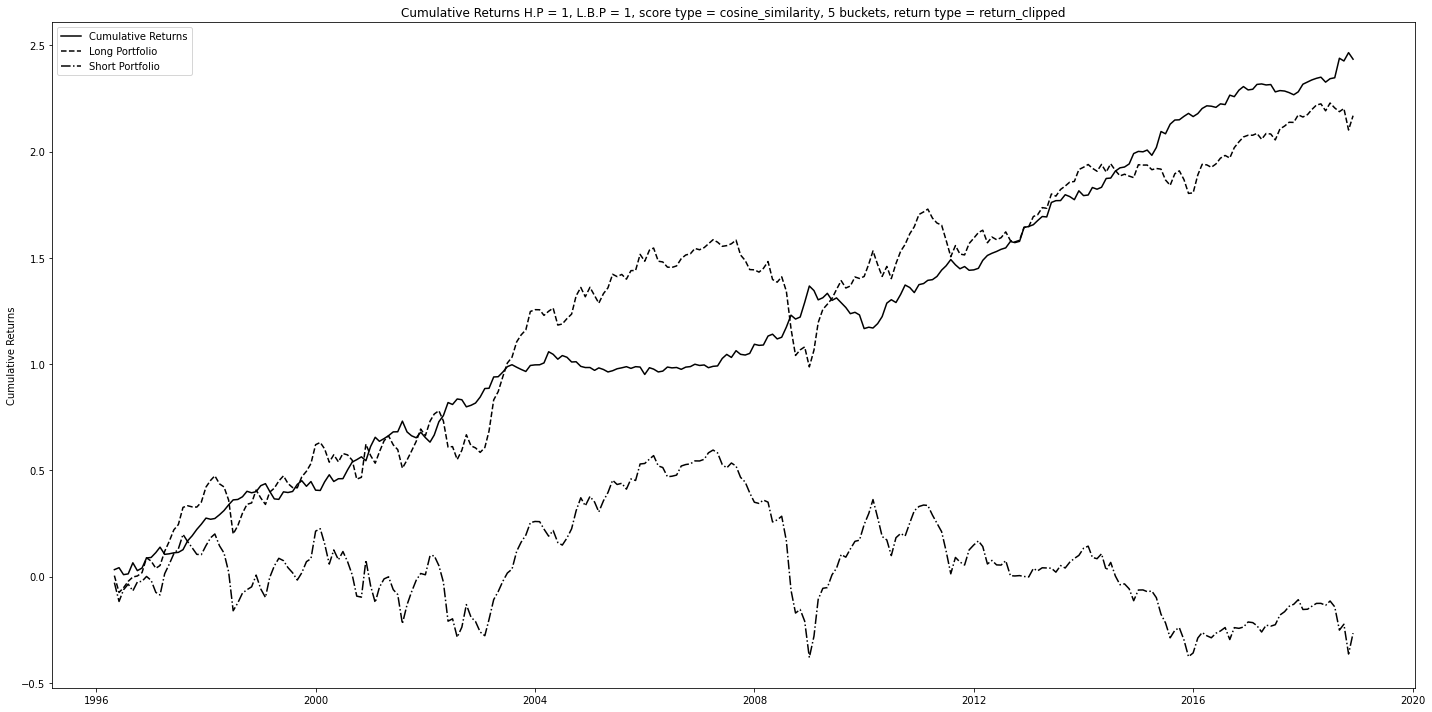

Value 
 
 
 
 
 Sharpe Ratio 
 1.03 
 
 
 Max Drawdown 
 -0.27 
 
 
 Hit Rate 
 64% 
 
 
 CAGR 
 12.87% 
 
 
 Monthly Returns 
 107bps 
 
 
 Monthly Vol 
 362bps

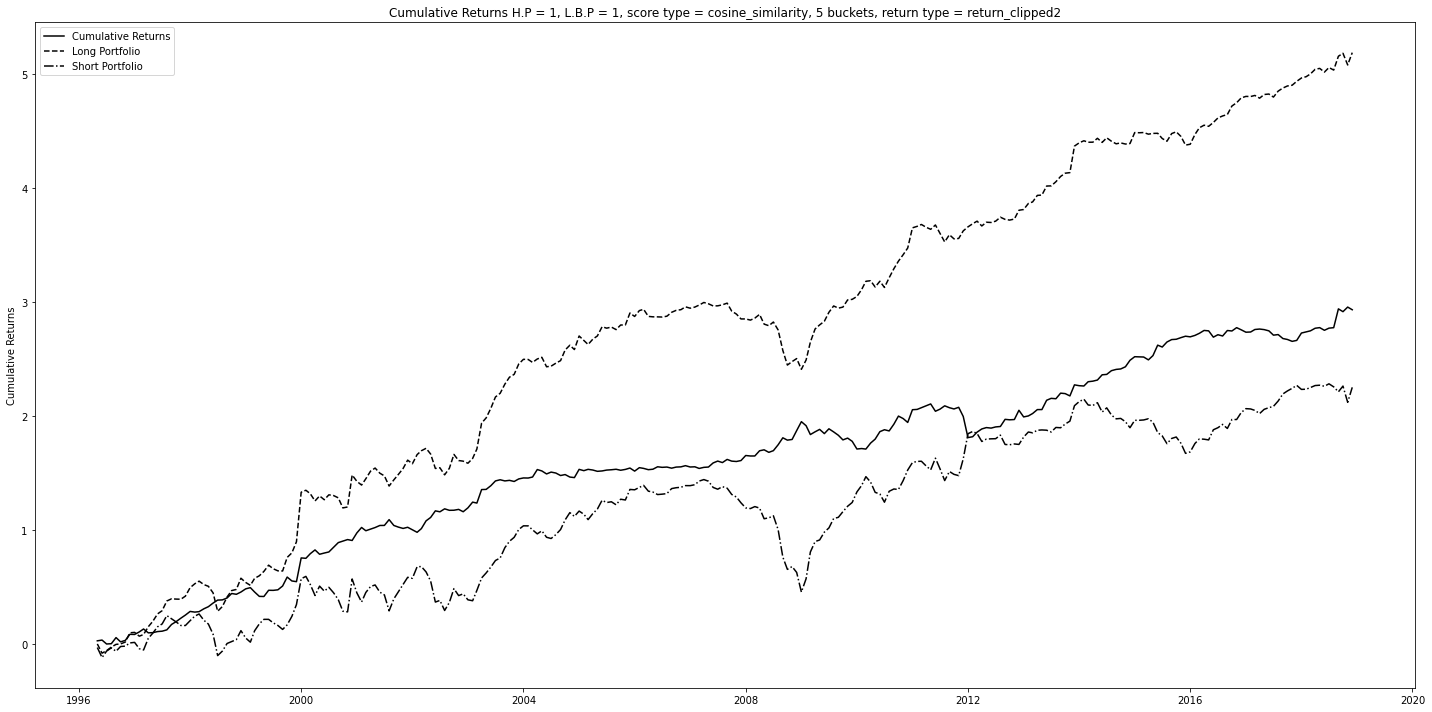

Value 
 
 
 
 
 Sharpe Ratio 
 0.81 
 
 
 Max Drawdown 
 -0.24 
 
 
 Hit Rate 
 58% 
 
 
 CAGR 
 9.35% 
 
 
 Monthly Returns 
 80bps 
 
 
 Monthly Vol 
 344bps

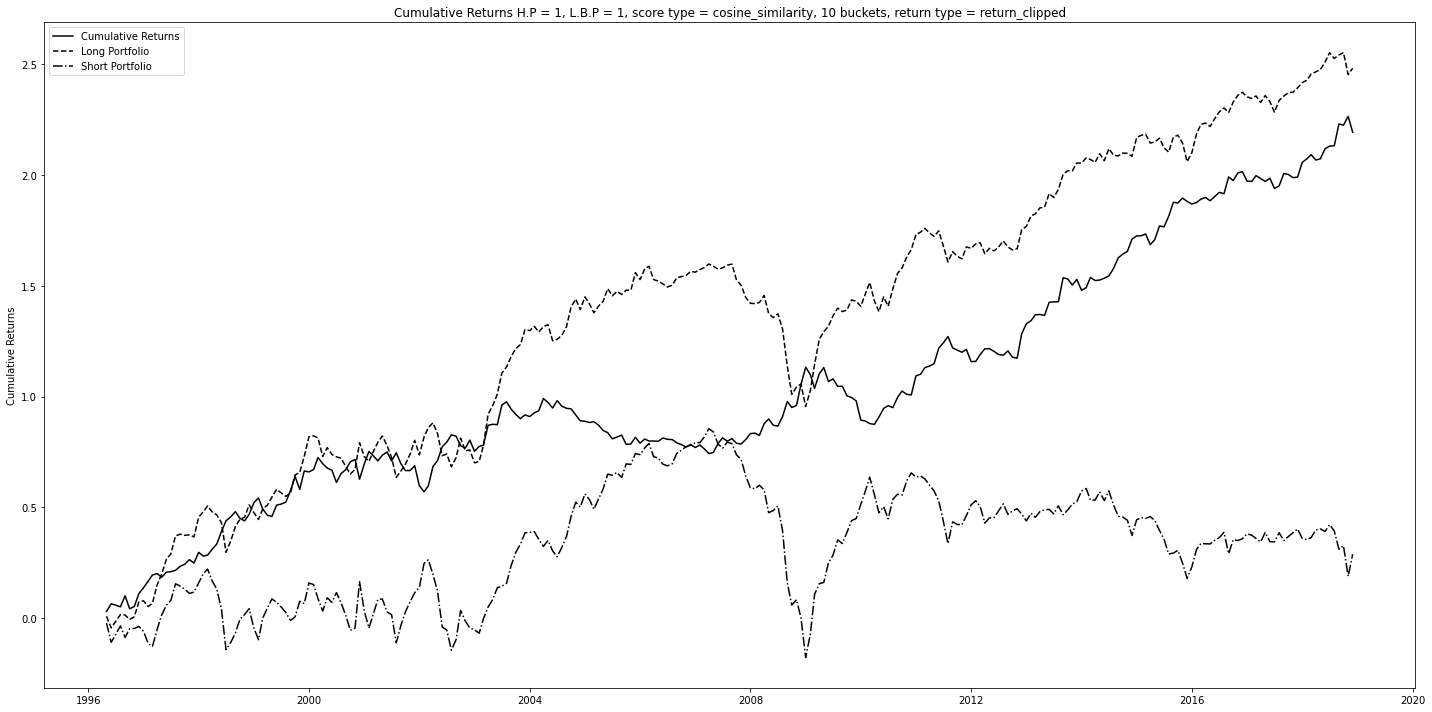

Value 
 
 
 
 
 Sharpe Ratio 
 -0.0 
 
 
 Max Drawdown 
 -22.2 
 
 
 Hit Rate 
 60% 
 
 
 CAGR 
 nan% 
 
 
 Monthly Returns 
 -7bps 
 
 
 Monthly Vol 
 5541bps

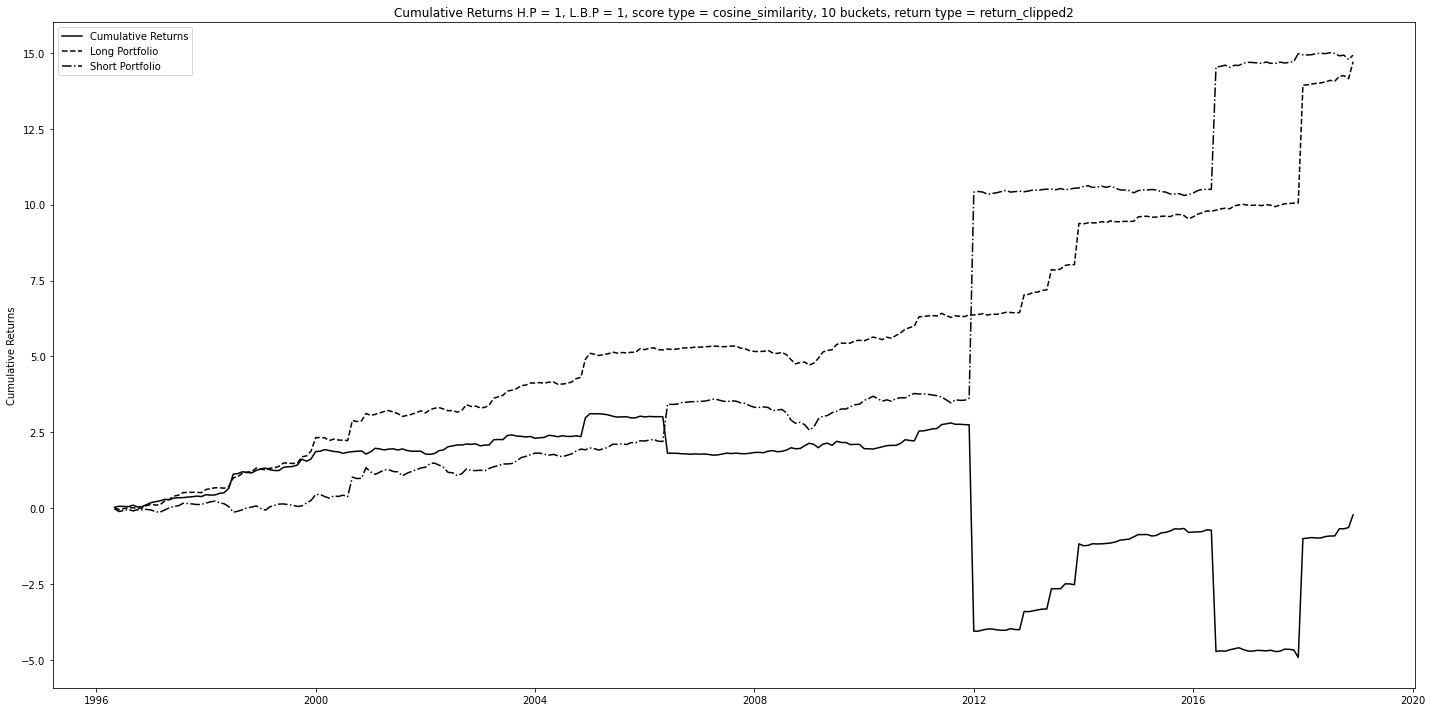

Value 
 
 
 
 
 Sharpe Ratio 
 1.94 
 
 
 Max Drawdown 
 -0.1 
 
 
 Hit Rate 
 74% 
 
 
 CAGR 
 9.39% 
 
 
 Monthly Returns 
 75bps 
 
 
 Monthly Vol 
 135bps

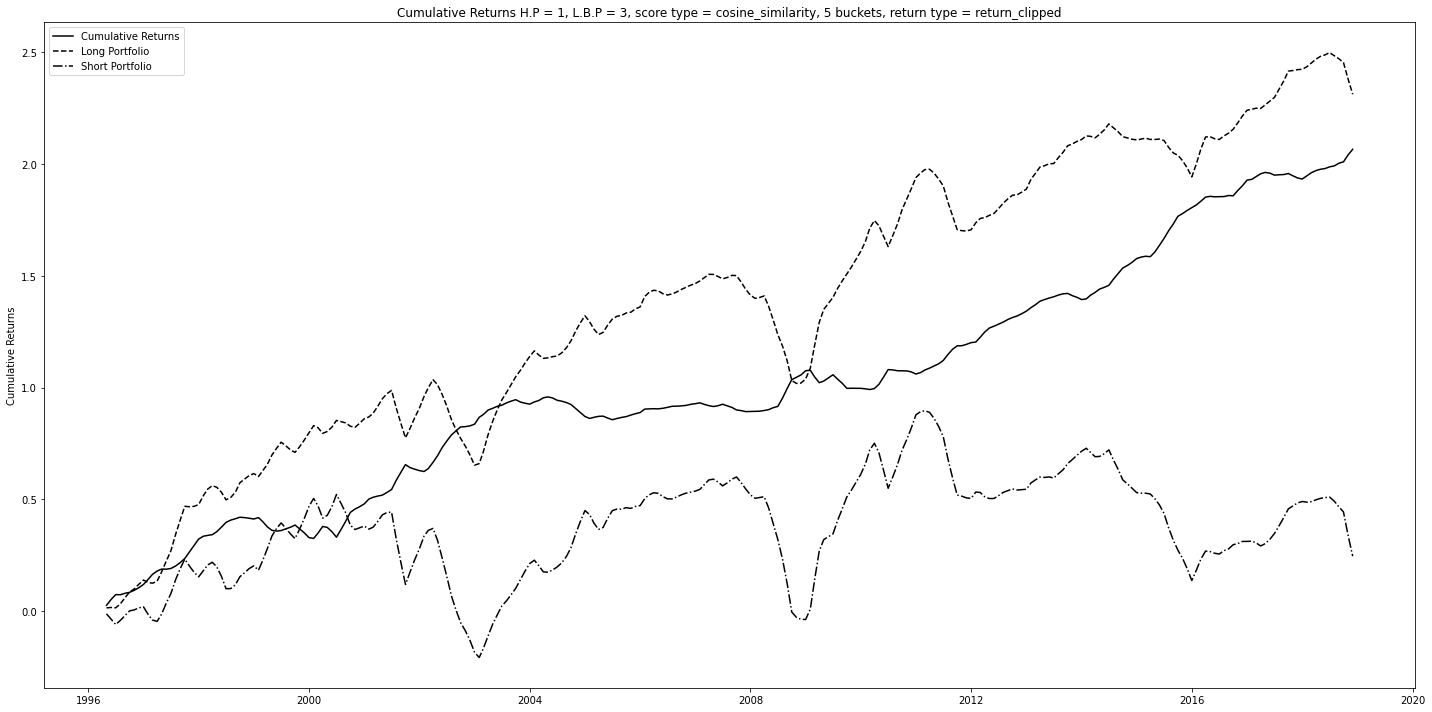

Value 
 
 
 
 
 Sharpe Ratio 
 1.67 
 
 
 Max Drawdown 
 -0.14 
 
 
 Hit Rate 
 73% 
 
 
 CAGR 
 8.85% 
 
 
 Monthly Returns 
 71bps 
 
 
 Monthly Vol 
 149bps

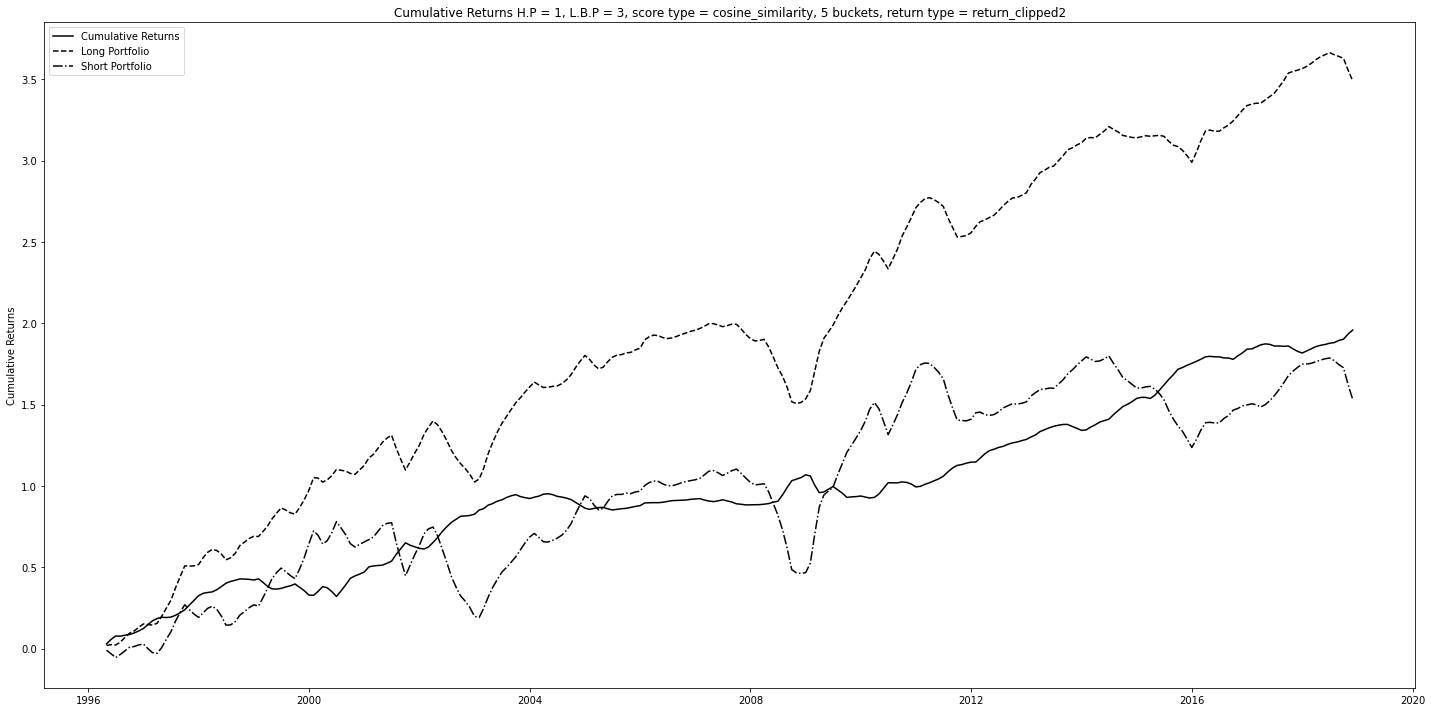

Value 
 
 
 
 
 Sharpe Ratio 
 1.15 
 
 
 Max Drawdown 
 -0.23 
 
 
 Hit Rate 
 62% 
 
 
 CAGR 
 6.59% 
 
 
 Monthly Returns 
 54bps 
 
 
 Monthly Vol 
 164bps

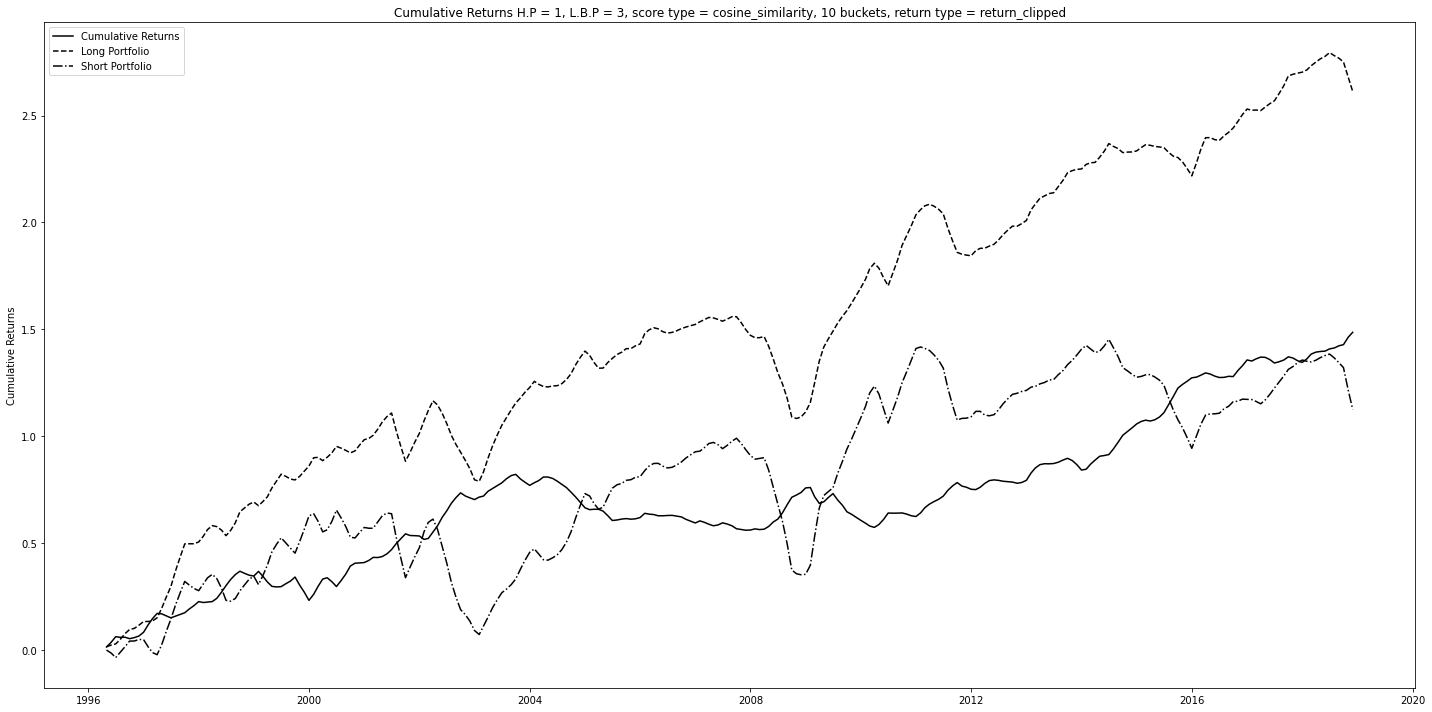

Value 
 
 
 
 
 Sharpe Ratio 
 1.22 
 
 
 Max Drawdown 
 -0.23 
 
 
 Hit Rate 
 63% 
 
 
 CAGR 
 7.55% 
 
 
 Monthly Returns 
 62bps 
 
 
 Monthly Vol 
 177bps

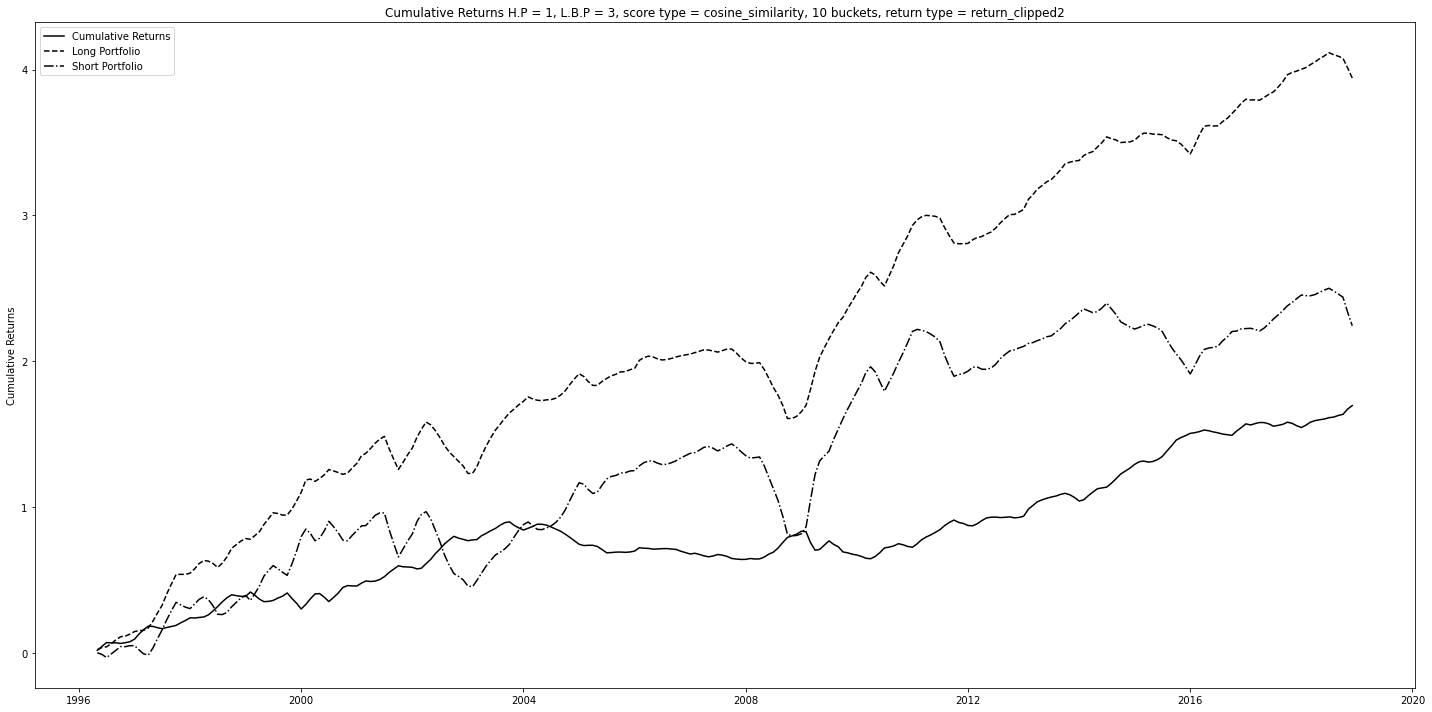

Value 
 
 
 
 
 Sharpe Ratio 
 2.61 
 
 
 Max Drawdown 
 -0.09 
 
 
 Hit Rate 
 76% 
 
 
 CAGR 
 9.13% 
 
 
 Monthly Returns 
 73bps 
 
 
 Monthly Vol 
 97bps

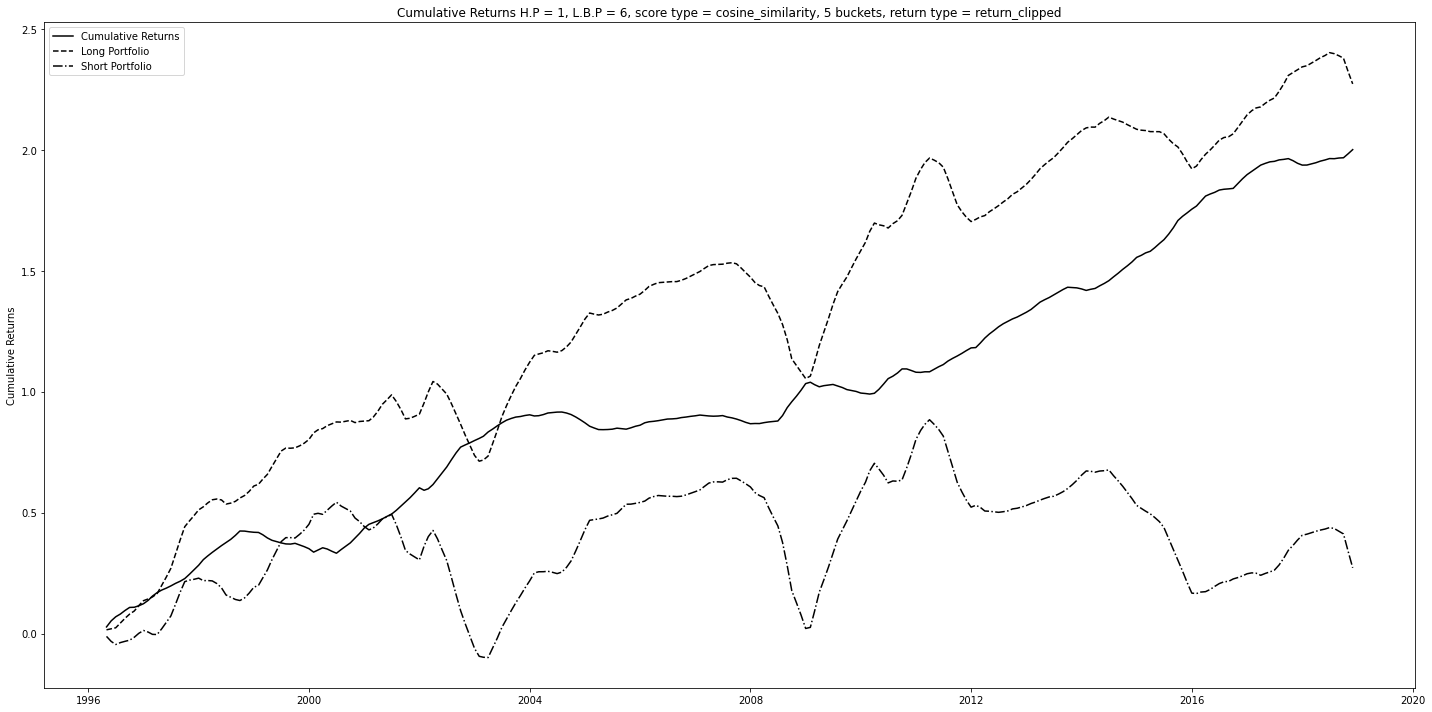

Value 
 
 
 
 
 Sharpe Ratio 
 2.37 
 
 
 Max Drawdown 
 -0.1 
 
 
 Hit Rate 
 75% 
 
 
 CAGR 
 8.87% 
 
 
 Monthly Returns 
 71bps 
 
 
 Monthly Vol 
 104bps

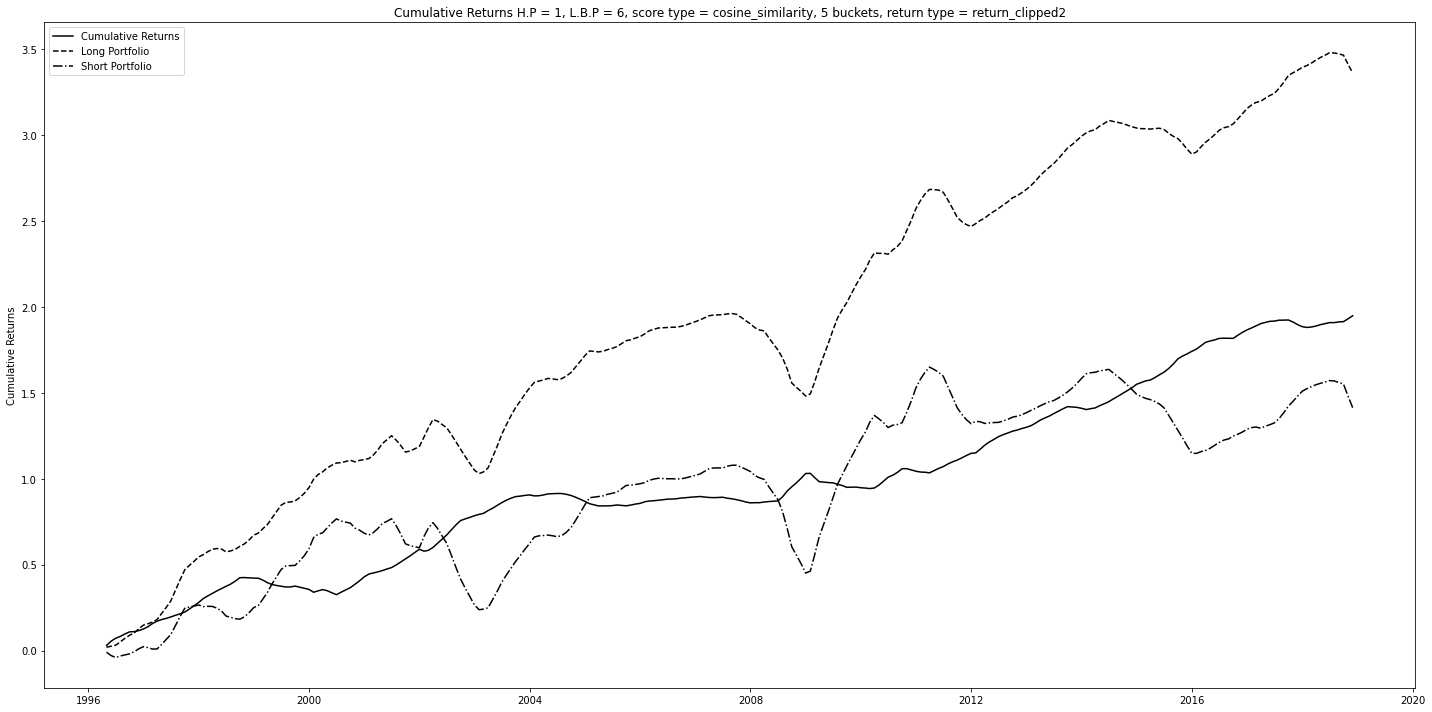

Value 
 
 
 
 
 Sharpe Ratio 
 1.54 
 
 
 Max Drawdown 
 -0.24 
 
 
 Hit Rate 
 65% 
 
 
 CAGR 
 6.14% 
 
 
 Monthly Returns 
 50bps 
 
 
 Monthly Vol 
 113bps

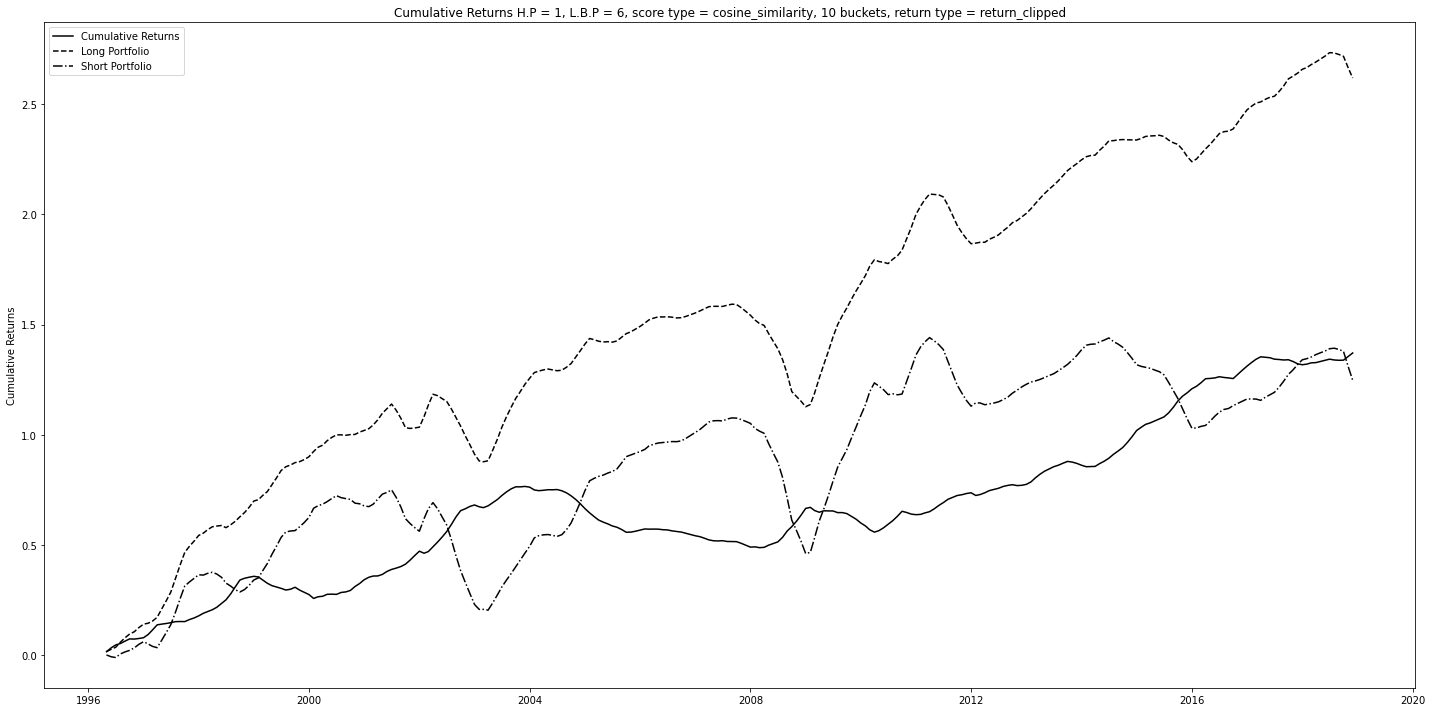

Value 
 
 
 
 
 Sharpe Ratio 
 1.7 
 
 
 Max Drawdown 
 -0.24 
 
 
 Hit Rate 
 67% 
 
 
 CAGR 
 7.17% 
 
 
 Monthly Returns 
 58bps 
 
 
 Monthly Vol 
 119bps

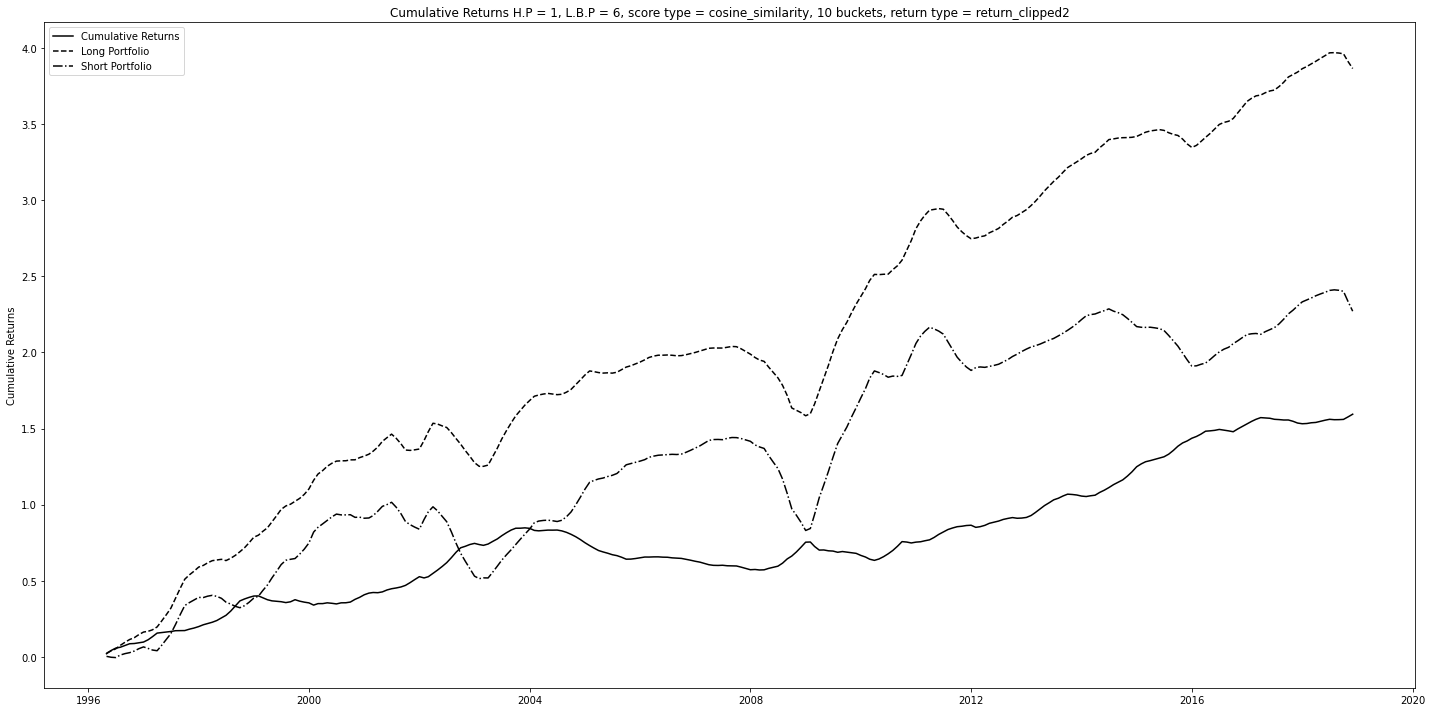

Value 
 
 
 
 
 Sharpe Ratio 
 1.86 
 
 
 Max Drawdown 
 -0.06 
 
 
 Hit Rate 
 82% 
 
 
 CAGR 
 7.6% 
 
 
 Monthly Returns 
 186bps 
 
 
 Monthly Vol 
 200bps

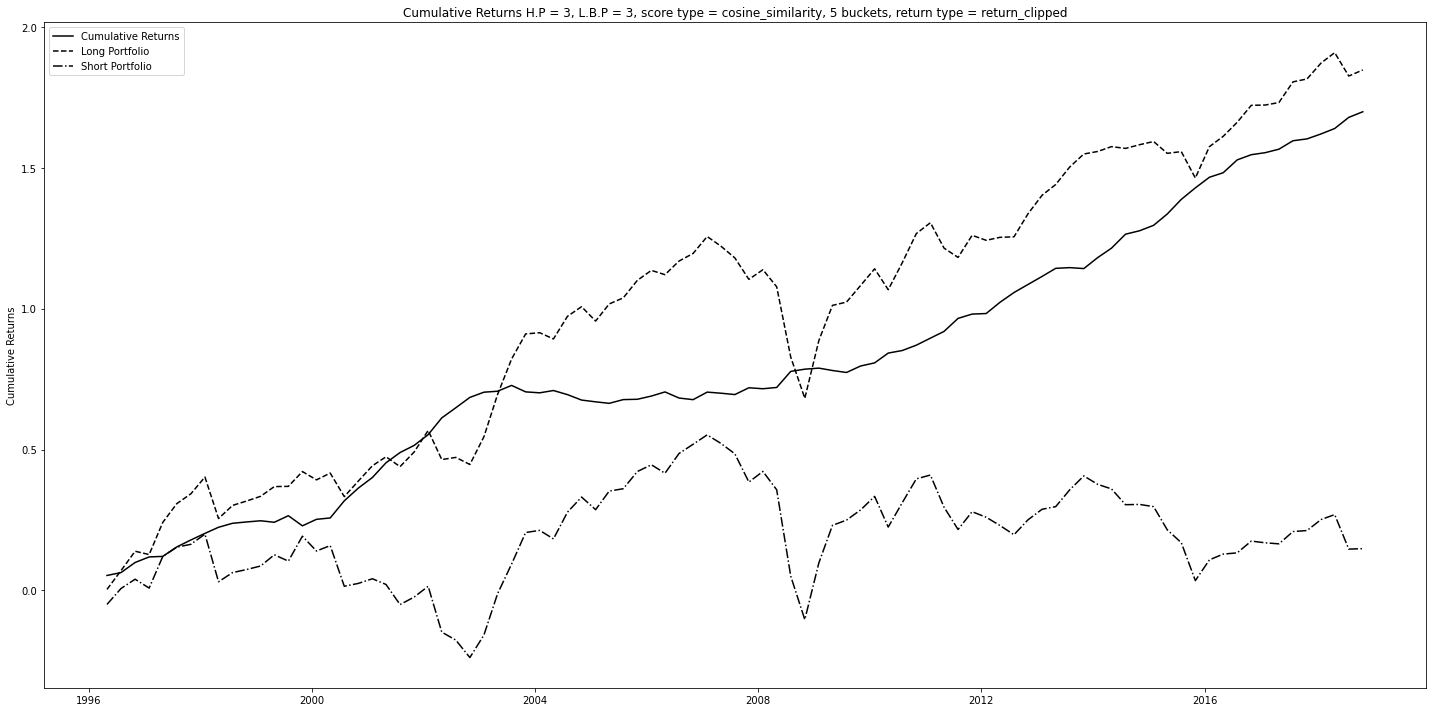

Value 
 
 
 
 
 Sharpe Ratio 
 1.59 
 
 
 Max Drawdown 
 -0.08 
 
 
 Hit Rate 
 76% 
 
 
 CAGR 
 8.67% 
 
 
 Monthly Returns 
 213bps 
 
 
 Monthly Vol 
 268bps

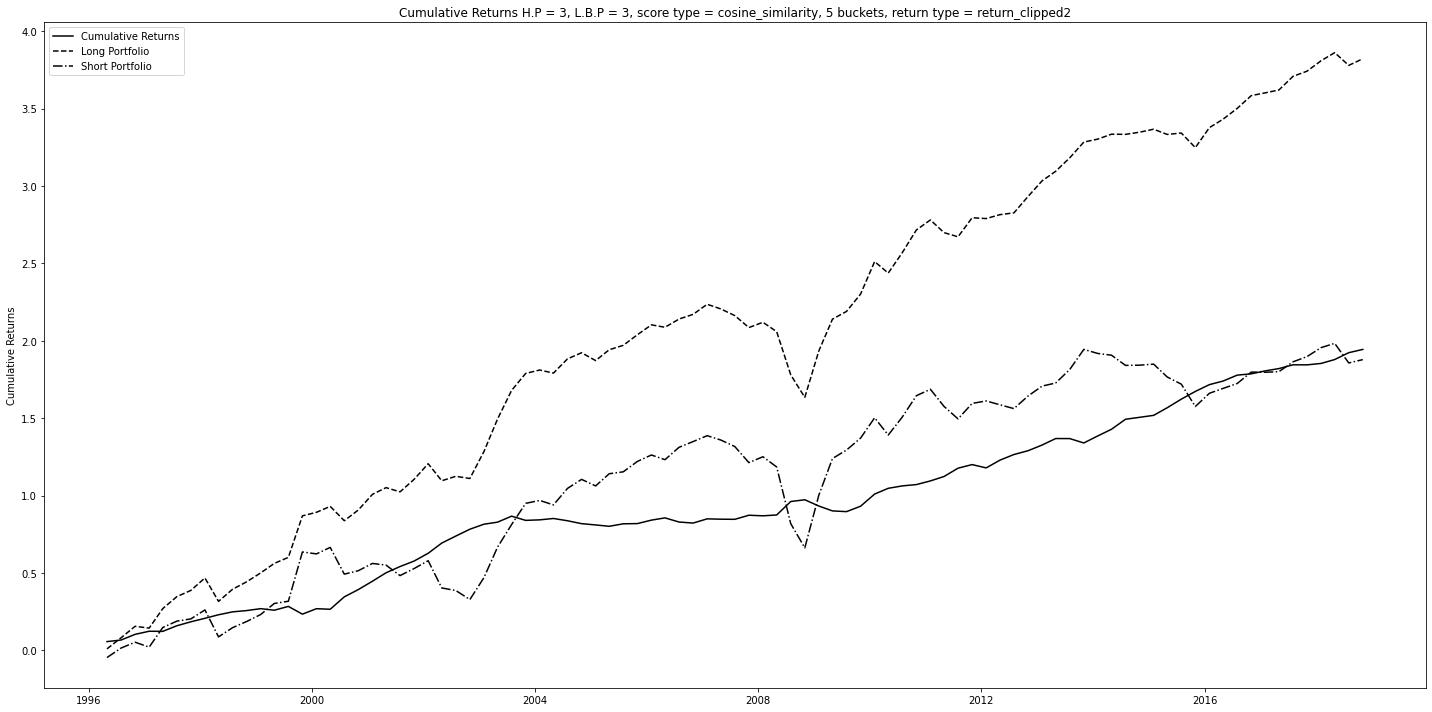

Value 
 
 
 
 
 Sharpe Ratio 
 1.41 
 
 
 Max Drawdown 
 -0.11 
 
 
 Hit Rate 
 78% 
 
 
 CAGR 
 6.94% 
 
 
 Monthly Returns 
 172bps 
 
 
 Monthly Vol 
 244bps

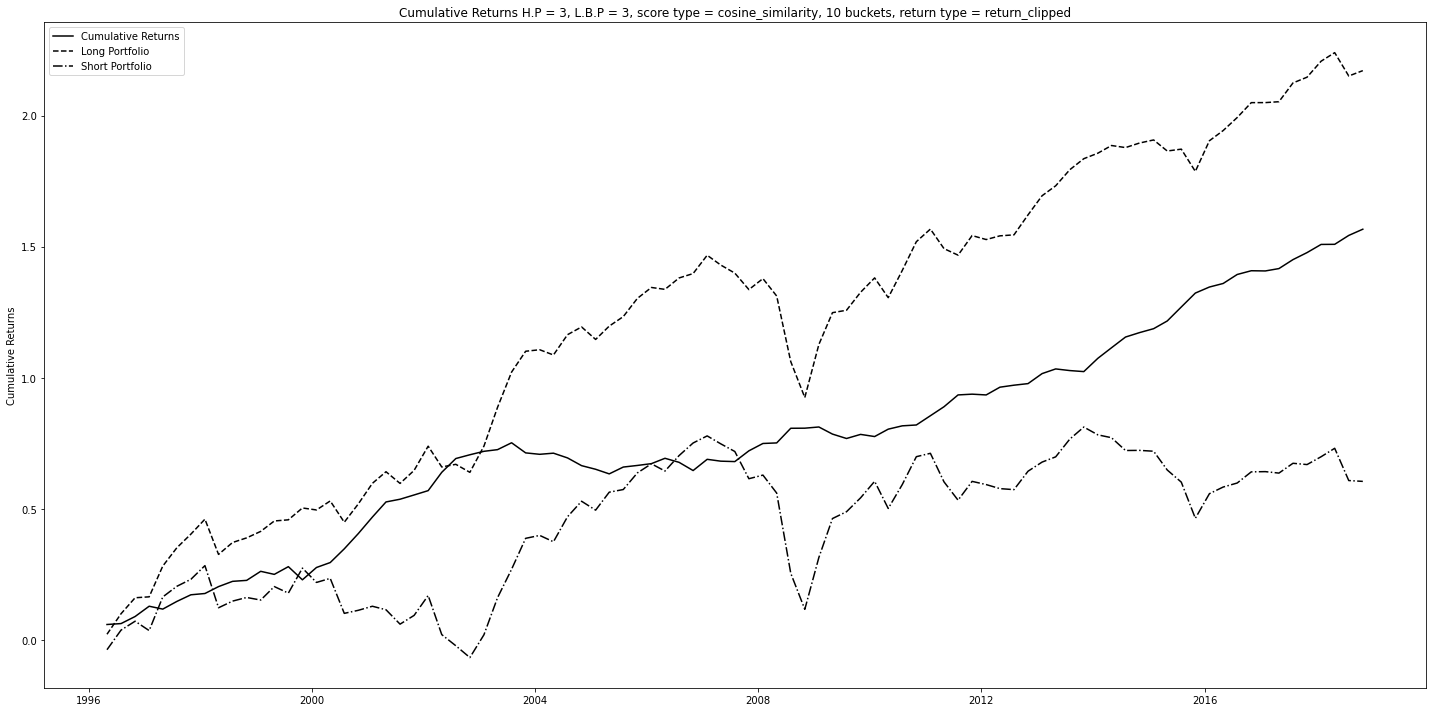

Value 
 
 
 
 
 Sharpe Ratio 
 1.54 
 
 
 Max Drawdown 
 -0.13 
 
 
 Hit Rate 
 79% 
 
 
 CAGR 
 9.79% 
 
 
 Monthly Returns 
 241bps 
 
 
 Monthly Vol 
 312bps

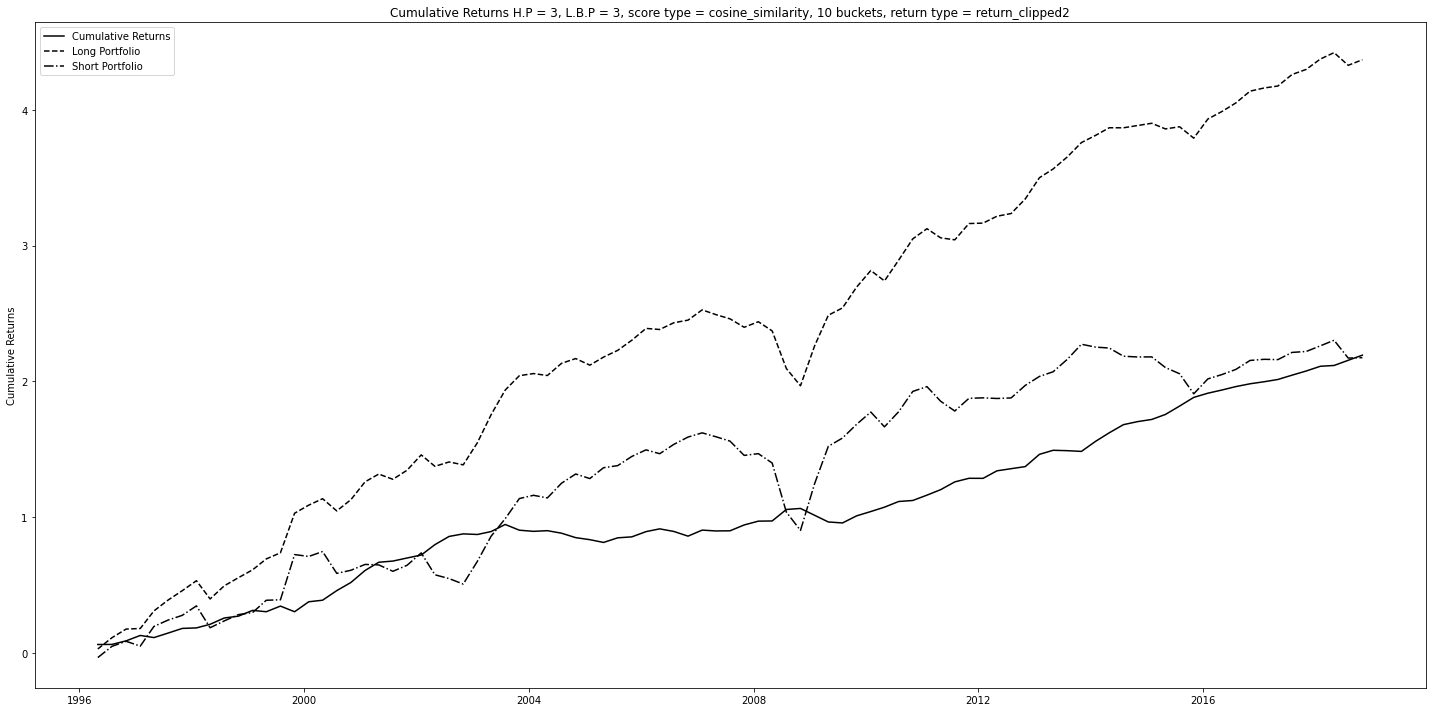

Value 
 
 
 
 
 Sharpe Ratio 
 2.07 
 
 
 Max Drawdown 
 -0.05 
 
 
 Hit Rate 
 84% 
 
 
 CAGR 
 7.39% 
 
 
 Monthly Returns 
 181bps 
 
 
 Monthly Vol 
 174bps

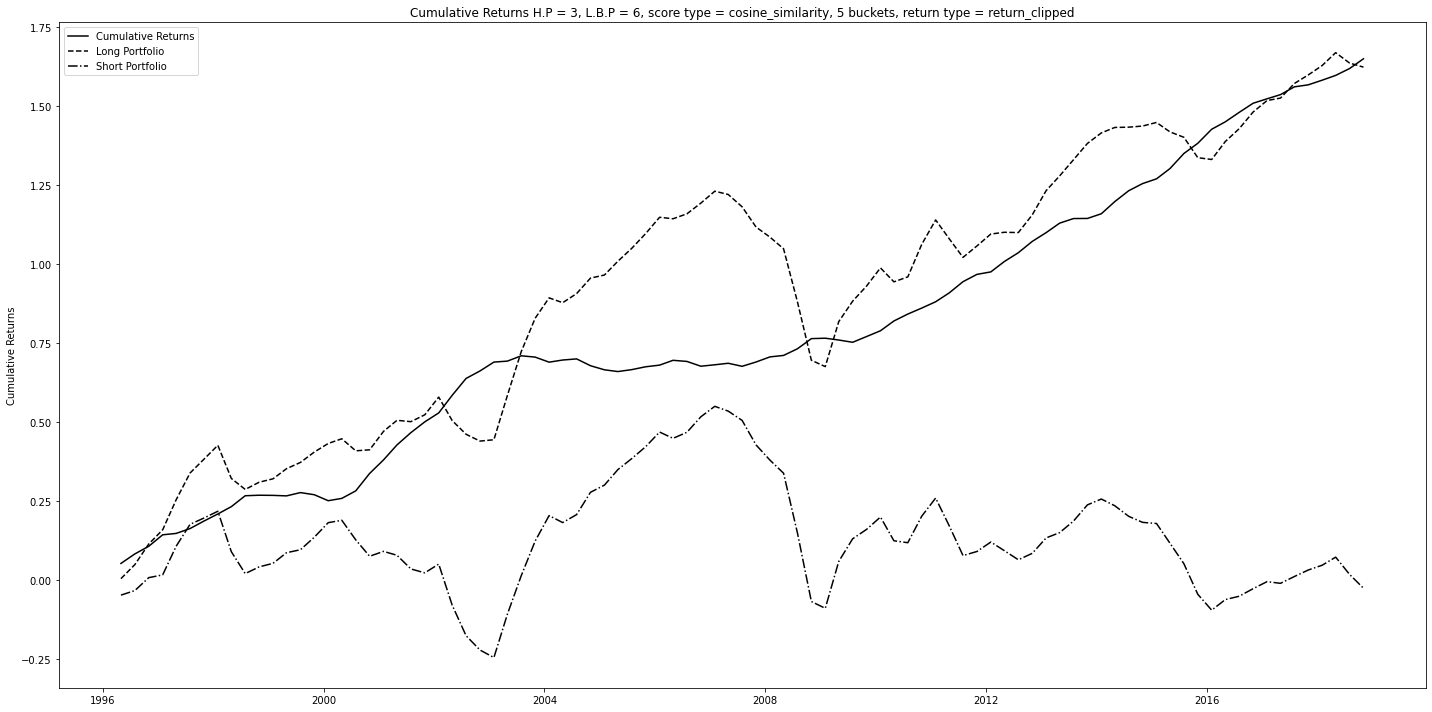

Value 
 
 
 
 
 Sharpe Ratio 
 1.97 
 
 
 Max Drawdown 
 -0.05 
 
 
 Hit Rate 
 84% 
 
 
 CAGR 
 8.51% 
 
 
 Monthly Returns 
 208bps 
 
 
 Monthly Vol 
 211bps

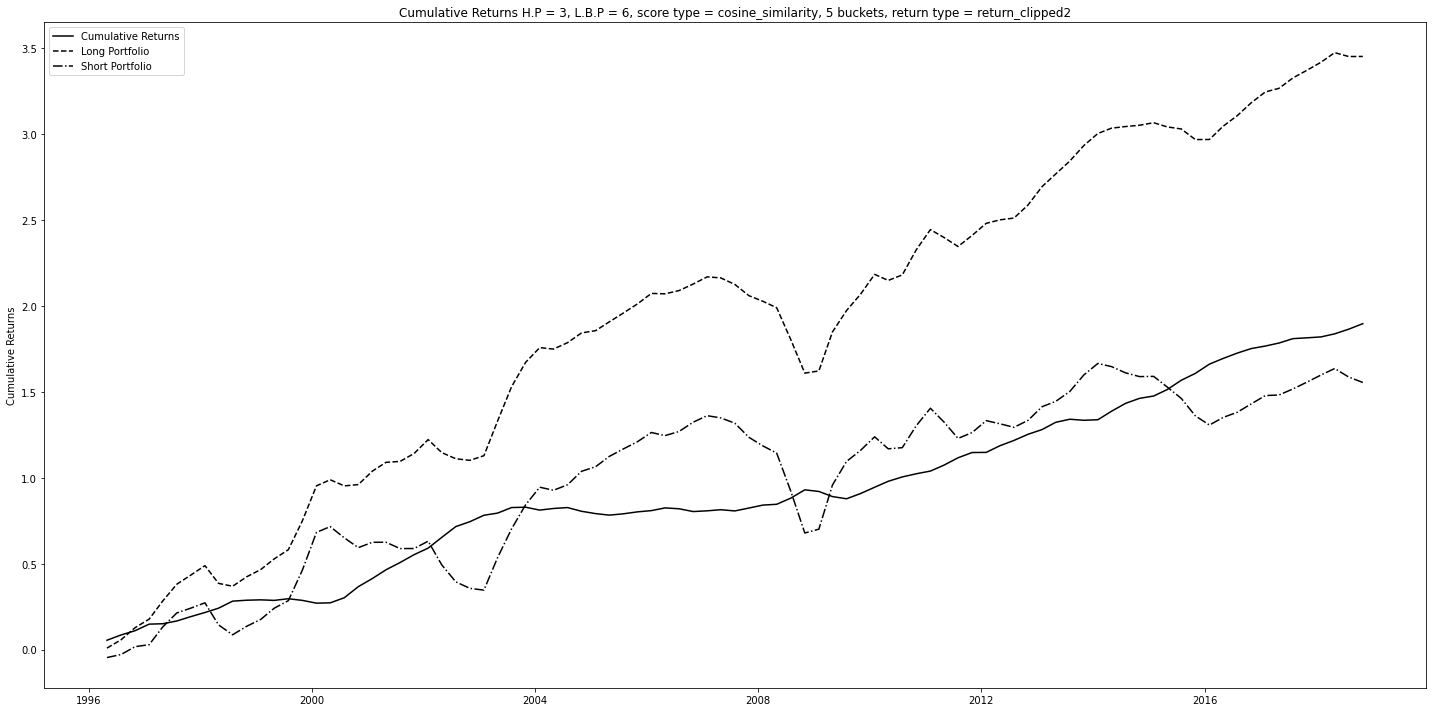

Value 
 
 
 
 
 Sharpe Ratio 
 1.56 
 
 
 Max Drawdown 
 -0.1 
 
 
 Hit Rate 
 80% 
 
 
 CAGR 
 6.71% 
 
 
 Monthly Returns 
 165bps 
 
 
 Monthly Vol 
 213bps

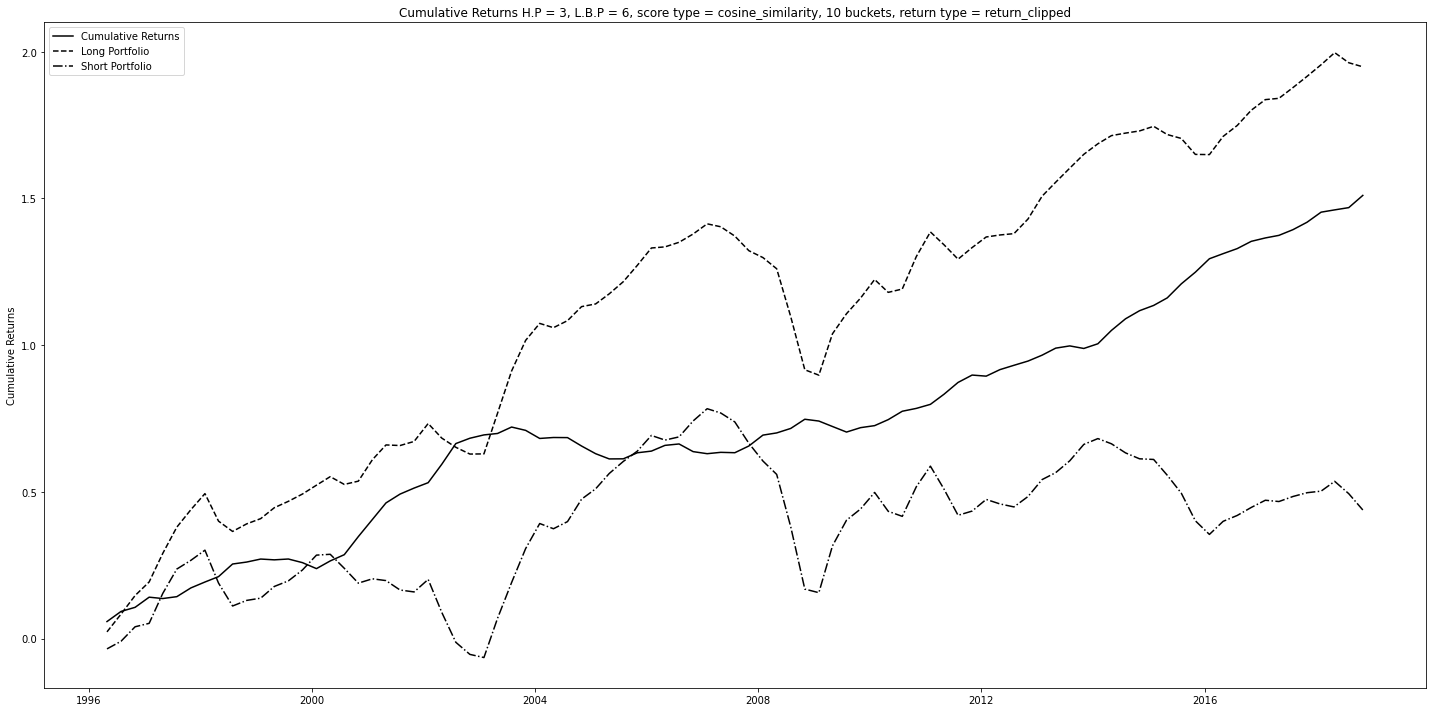

Value 
 
 
 
 
 Sharpe Ratio 
 1.87 
 
 
 Max Drawdown 
 -0.1 
 
 
 Hit Rate 
 86% 
 
 
 CAGR 
 9.61% 
 
 
 Monthly Returns 
 235bps 
 
 
 Monthly Vol 
 251bps

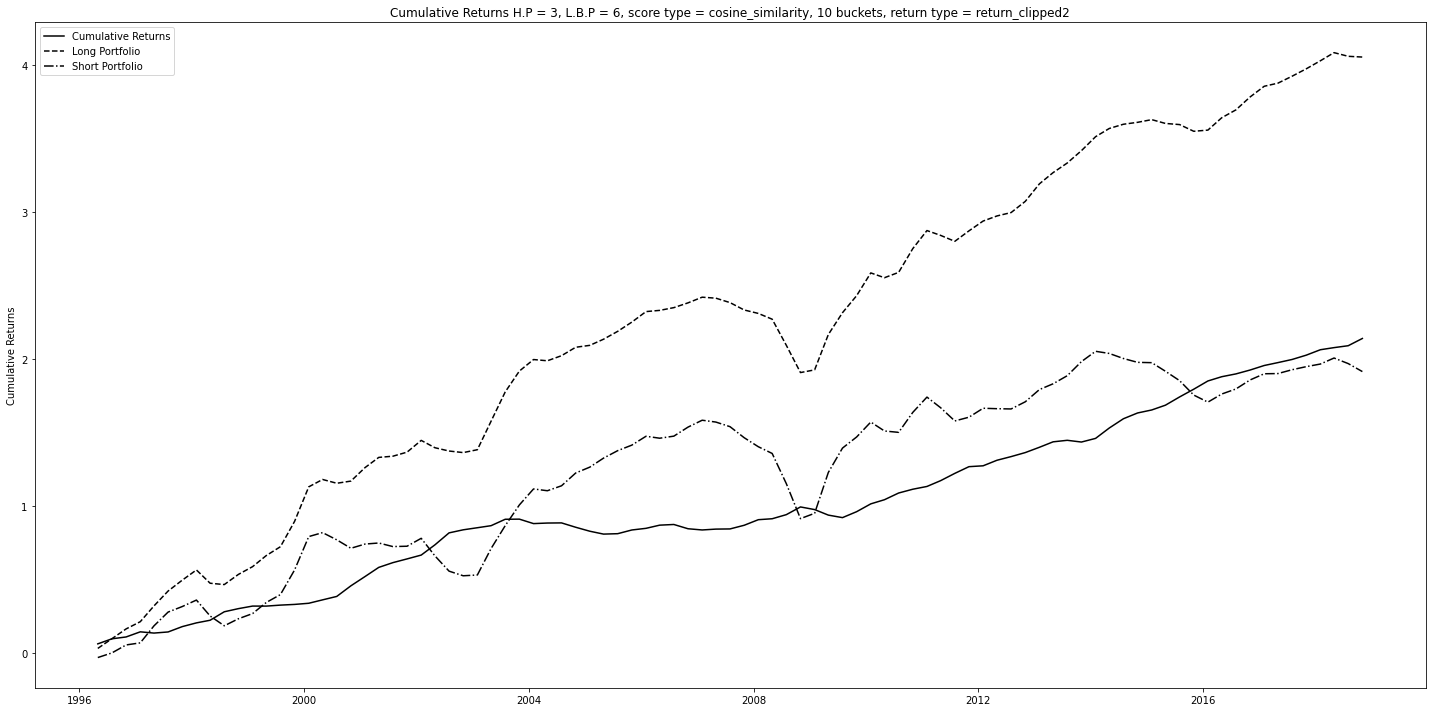

Value 
 
 
 
 
 Sharpe Ratio 
 1.58 
 
 
 Max Drawdown 
 -0.05 
 
 
 Hit Rate 
 89% 
 
 
 CAGR 
 5.59% 
 
 
 Monthly Returns 
 278bps 
 
 
 Monthly Vol 
 248bps

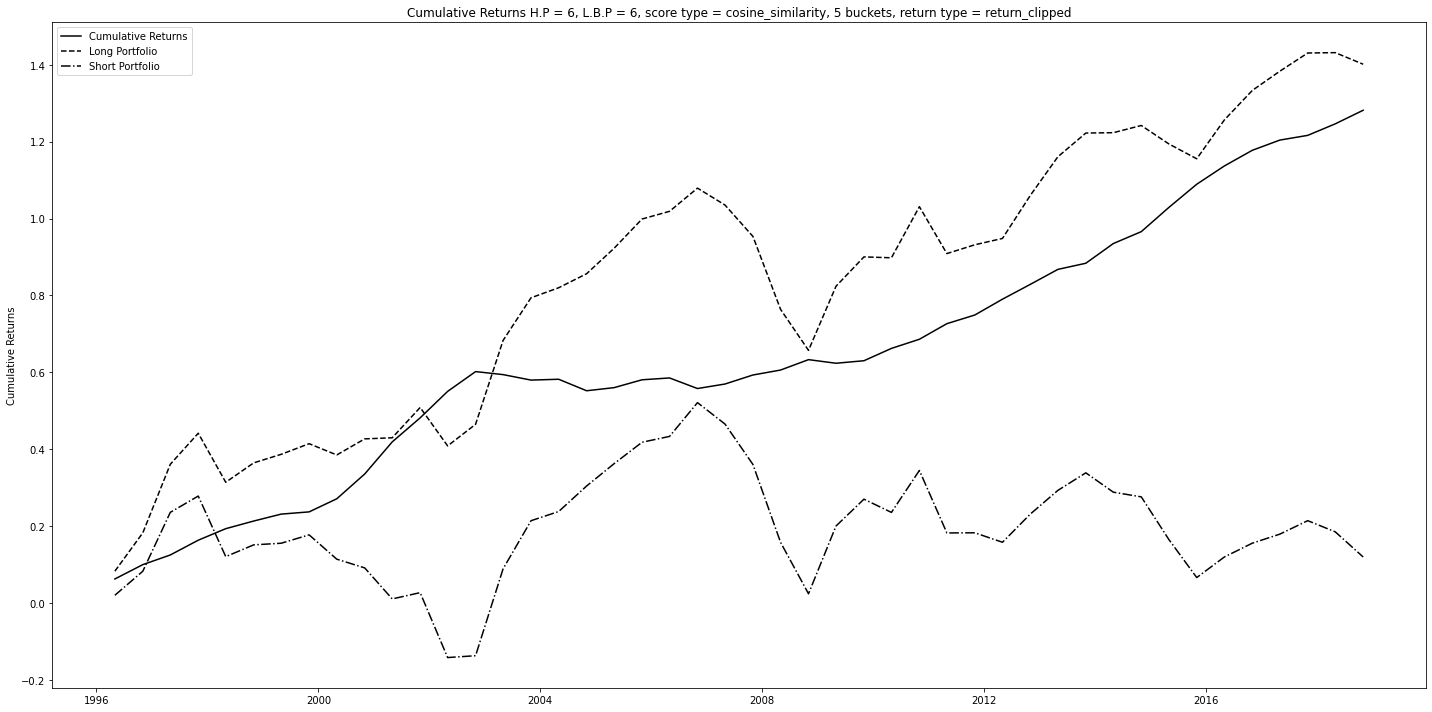

Value 
 
 
 
 
 Sharpe Ratio 
 1.61 
 
 
 Max Drawdown 
 -0.07 
 
 
 Hit Rate 
 91% 
 
 
 CAGR 
 7.8% 
 
 
 Monthly Returns 
 388bps 
 
 
 Monthly Vol 
 340bps

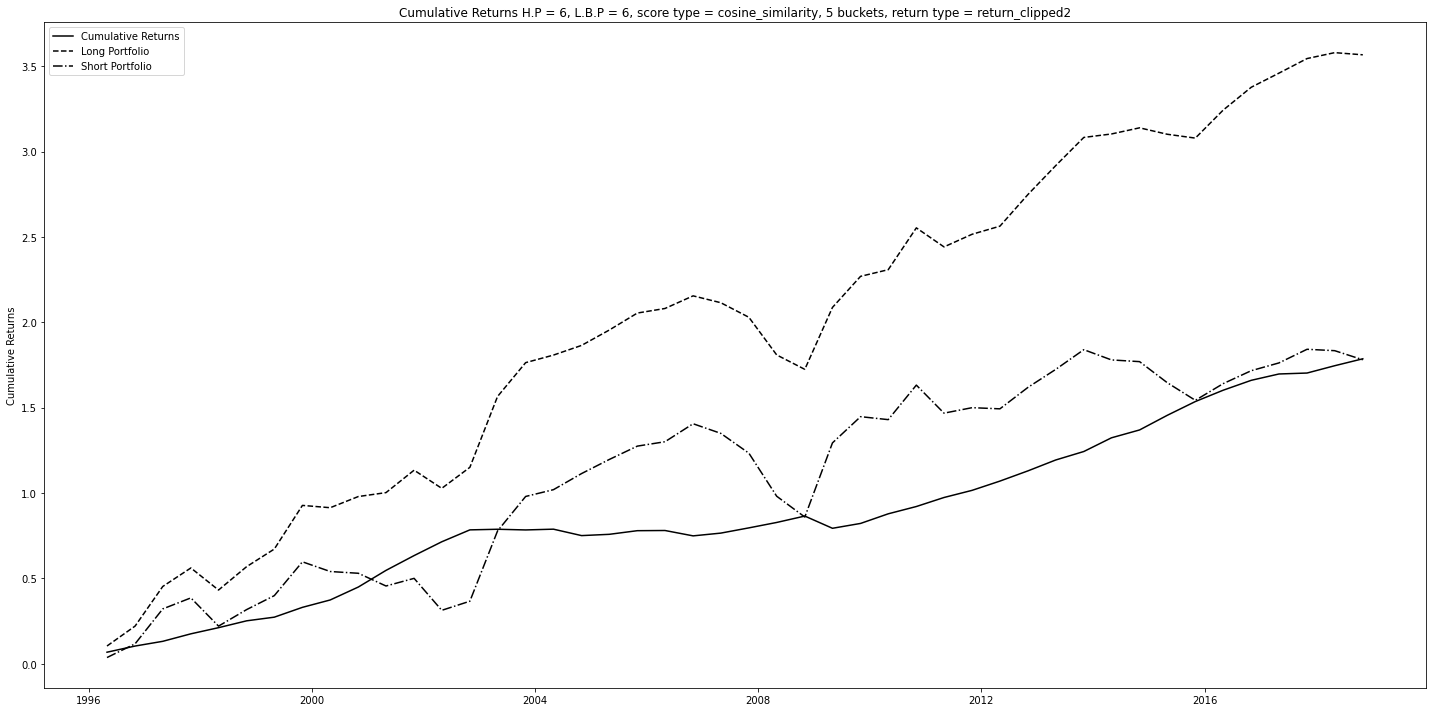

Value 
 
 
 
 
 Sharpe Ratio 
 1.2 
 
 
 Max Drawdown 
 -0.06 
 
 
 Hit Rate 
 78% 
 
 
 CAGR 
 5.19% 
 
 
 Monthly Returns 
 260bps 
 
 
 Monthly Vol 
 307bps

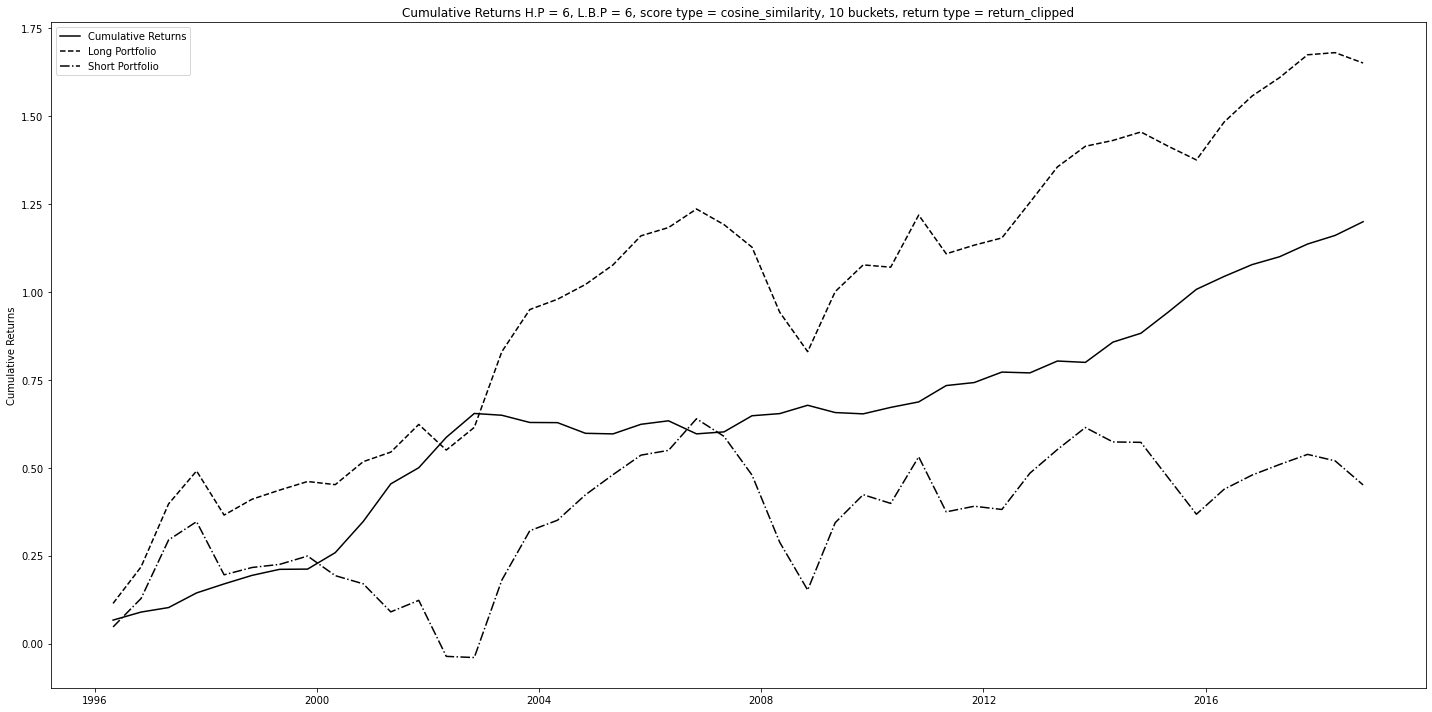

Value 
 
 
 
 
 Sharpe Ratio 
 1.71 
 
 
 Max Drawdown 
 -0.06 
 
 
 Hit Rate 
 93% 
 
 
 CAGR 
 9.13% 
 
 
 Monthly Returns 
 453bps 
 
 
 Monthly Vol 
 375bps

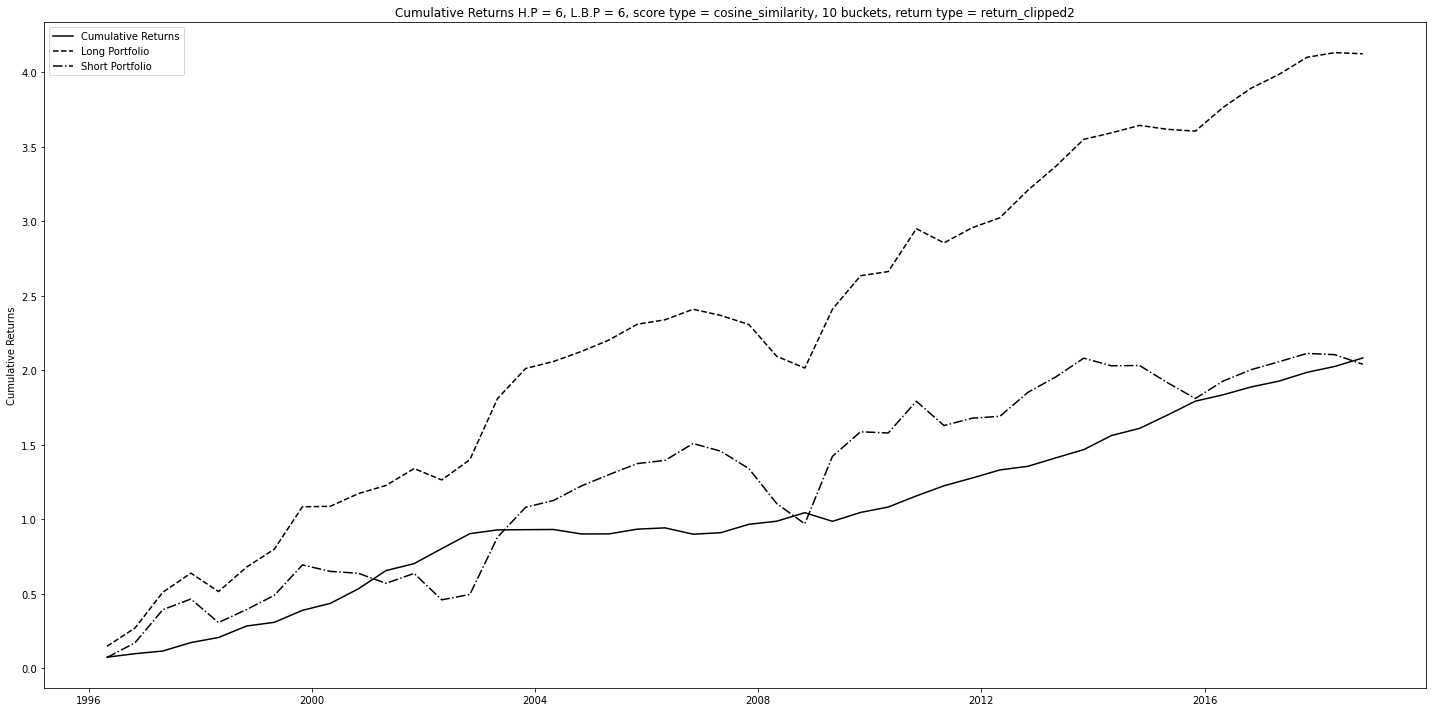

Value 
 
 
 
 
 Sharpe Ratio 
 1.73 
 
 
 Max Drawdown 
 -0.12 
 
 
 Hit Rate 
 69% 
 
 
 CAGR 
 15.63% 
 
 
 Monthly Returns 
 124bps 
 
 
 Monthly Vol 
 249bps

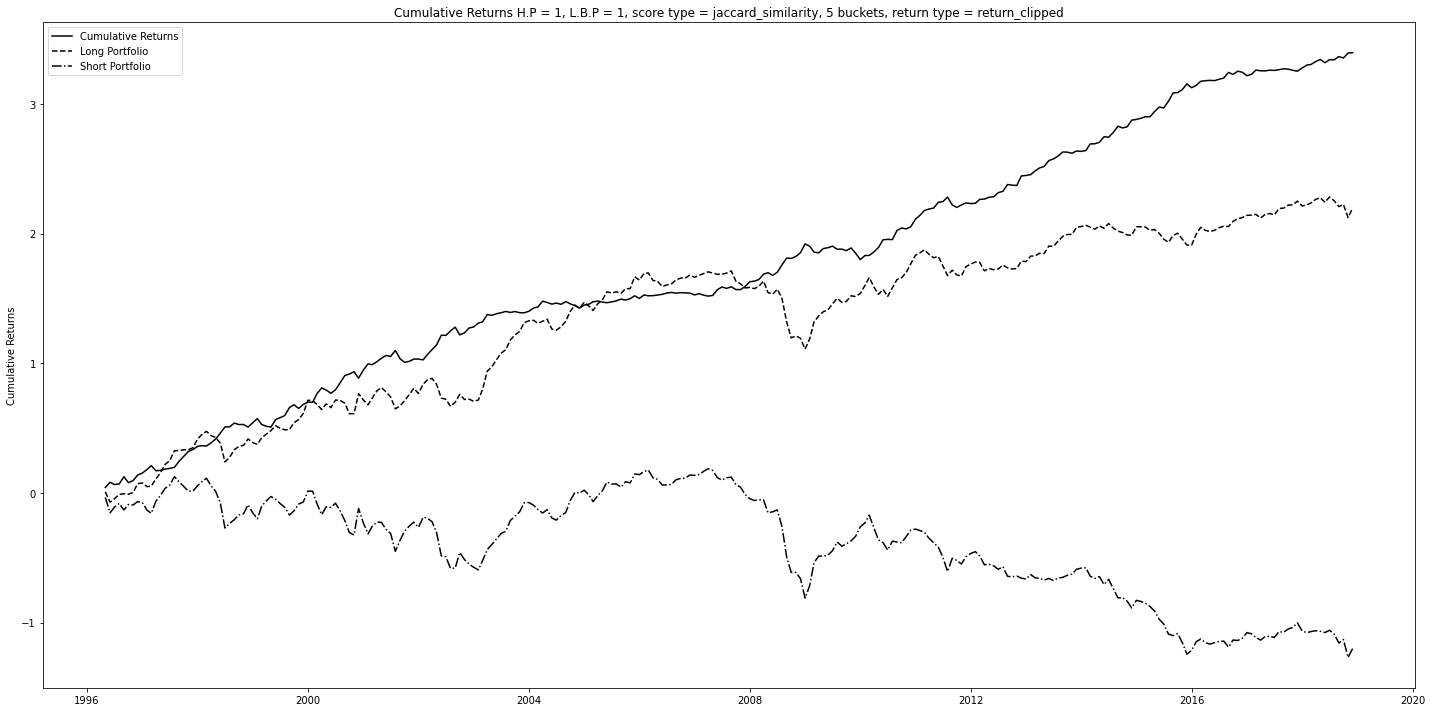

Value 
 
 
 
 
 Sharpe Ratio 
 1.08 
 
 
 Max Drawdown 
 -0.33 
 
 
 Hit Rate 
 69% 
 
 
 CAGR 
 15.85% 
 
 
 Monthly Returns 
 132bps 
 
 
 Monthly Vol 
 422bps

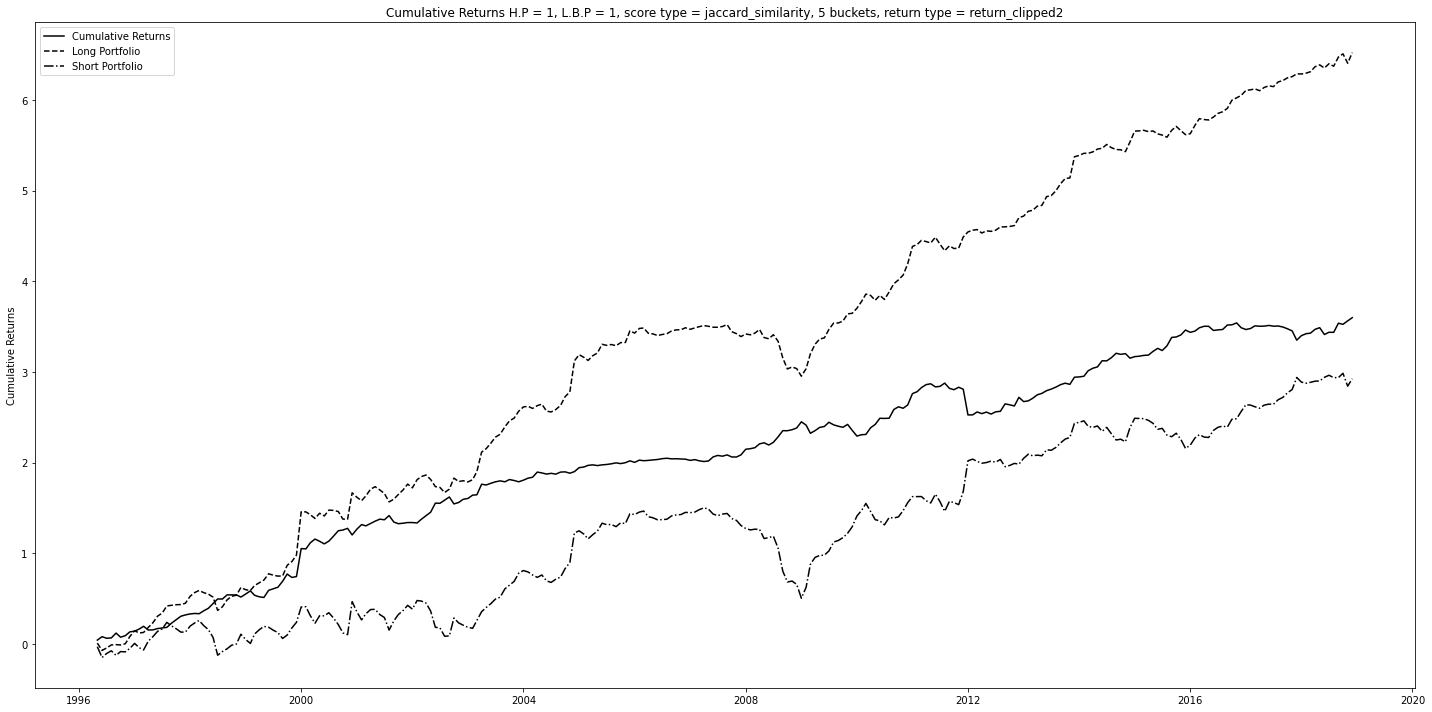

Value 
 
 
 
 
 Sharpe Ratio 
 1.22 
 
 
 Max Drawdown 
 -0.15 
 
 
 Hit Rate 
 66% 
 
 
 CAGR 
 15.32% 
 
 
 Monthly Returns 
 125bps 
 
 
 Monthly Vol 
 356bps

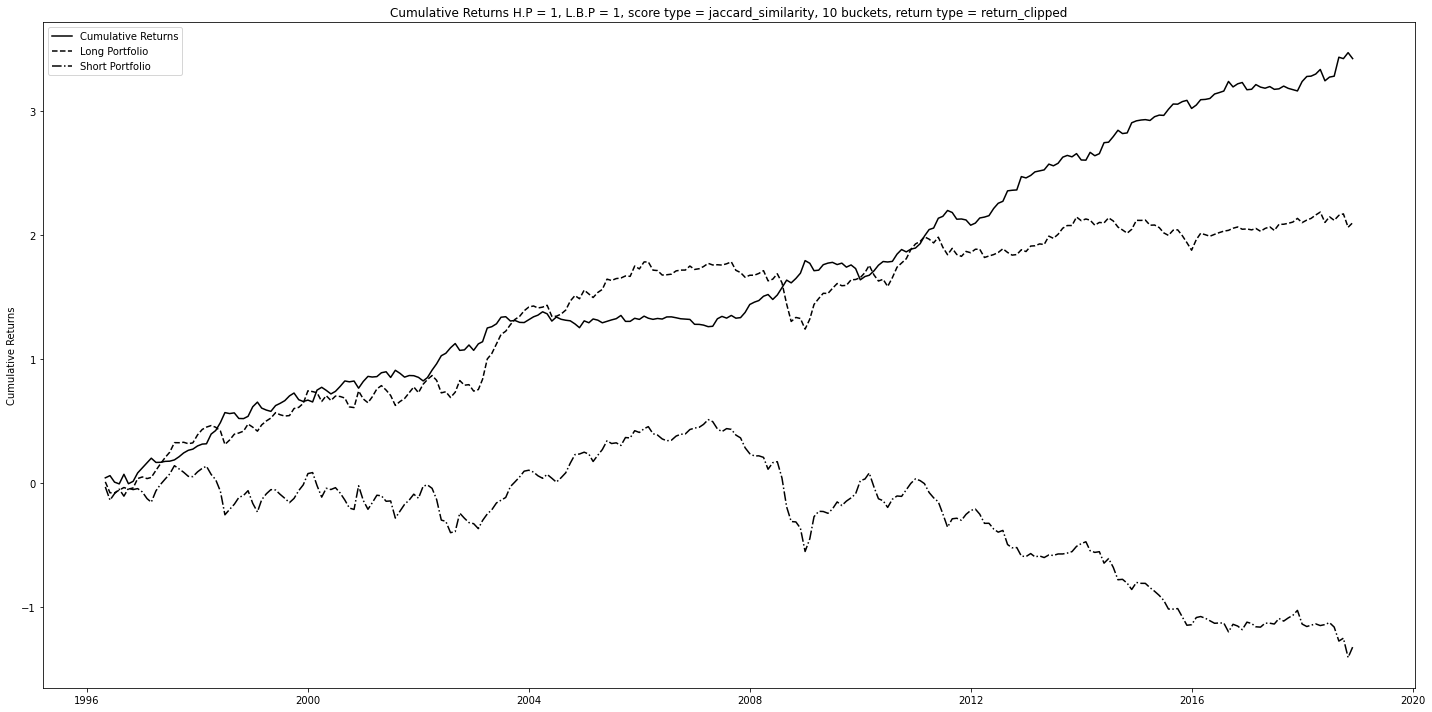

Value 
 
 
 
 
 Sharpe Ratio 
 -0.09 
 
 
 Max Drawdown 
 -4.18 
 
 
 Hit Rate 
 67% 
 
 
 CAGR 
 62.79% 
 
 
 Monthly Returns 
 -165bps 
 
 
 Monthly Vol 
 6305bps

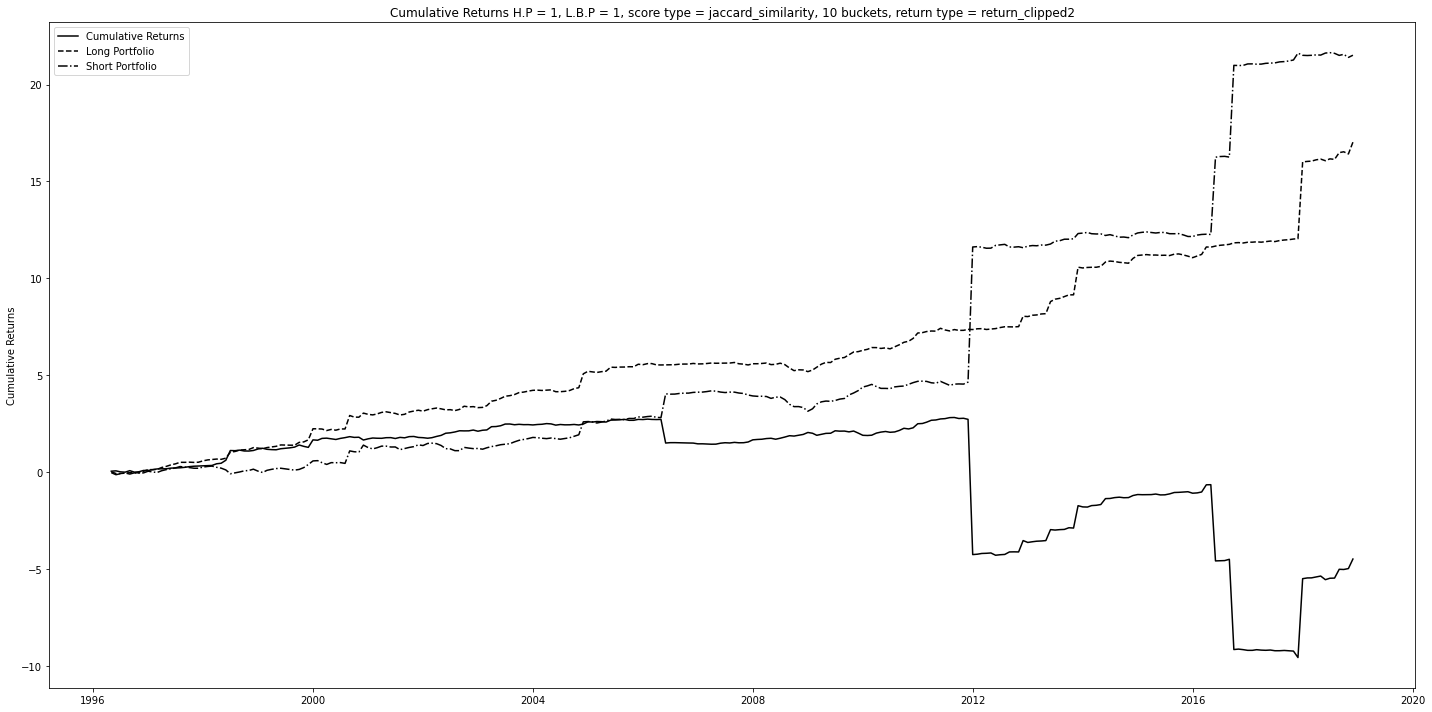

Value 
 
 
 
 
 Sharpe Ratio 
 2.79 
 
 
 Max Drawdown 
 -0.07 
 
 
 Hit Rate 
 79% 
 
 
 CAGR 
 14.91% 
 
 
 Monthly Returns 
 117bps 
 
 
 Monthly Vol 
 145bps

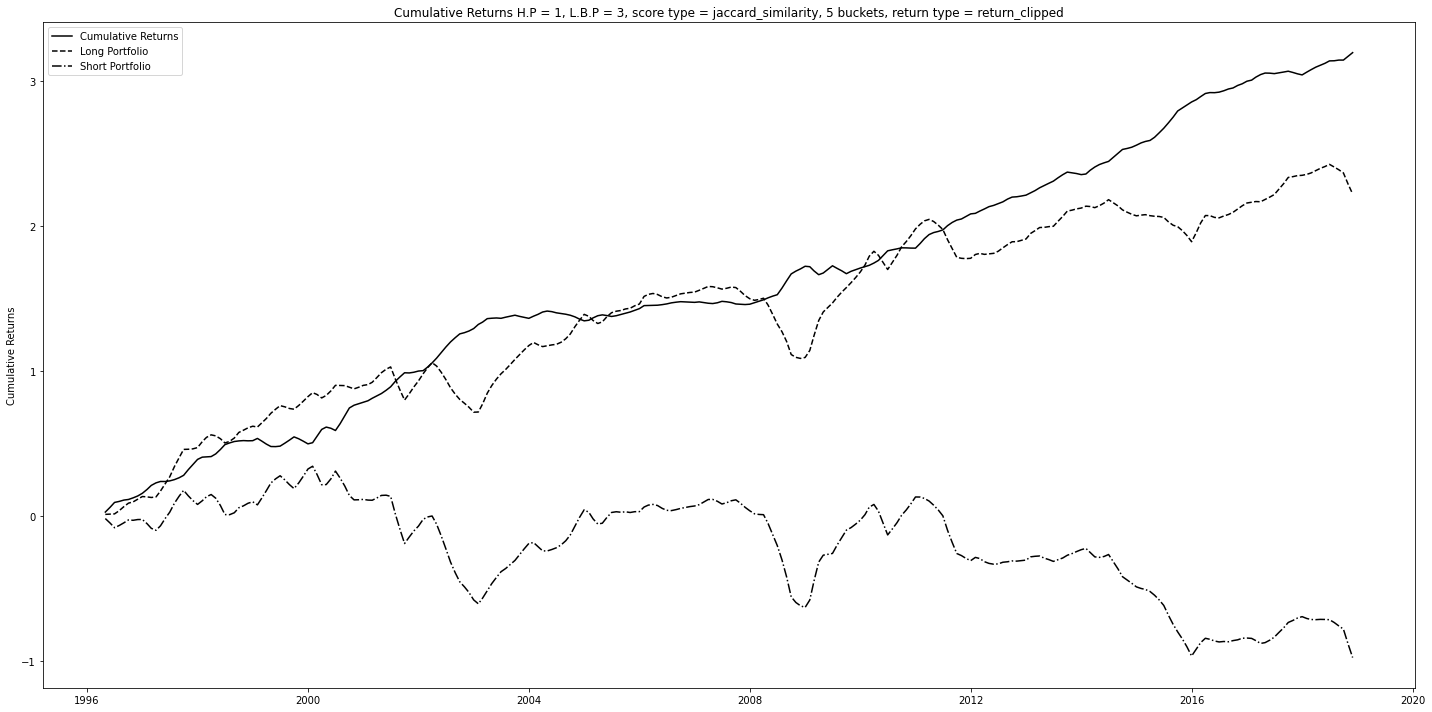

Value 
 
 
 
 
 Sharpe Ratio 
 2.3 
 
 
 Max Drawdown 
 -0.12 
 
 
 Hit Rate 
 77% 
 
 
 CAGR 
 13.92% 
 
 
 Monthly Returns 
 110bps 
 
 
 Monthly Vol 
 166bps

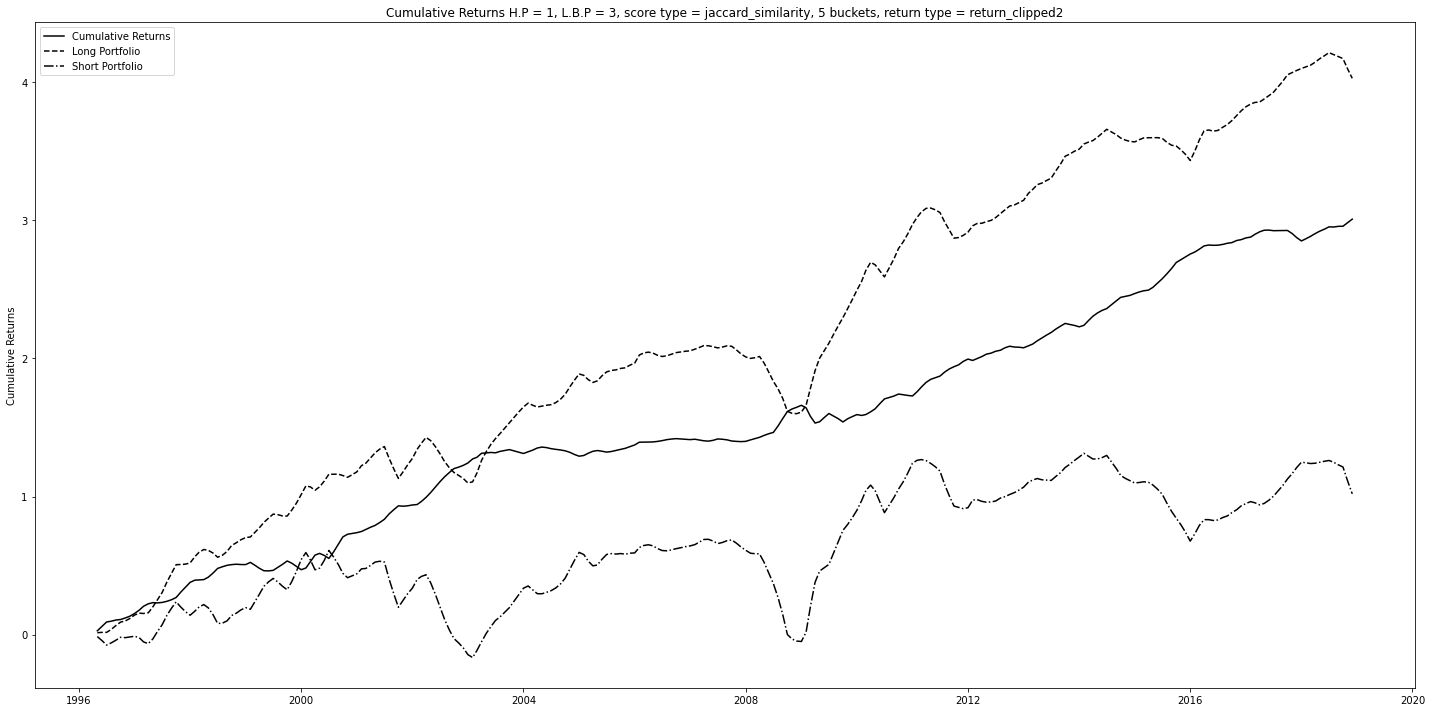

Value 
 
 
 
 
 Sharpe Ratio 
 2.22 
 
 
 Max Drawdown 
 -0.14 
 
 
 Hit Rate 
 72% 
 
 
 CAGR 
 15.11% 
 
 
 Monthly Returns 
 119bps 
 
 
 Monthly Vol 
 186bps

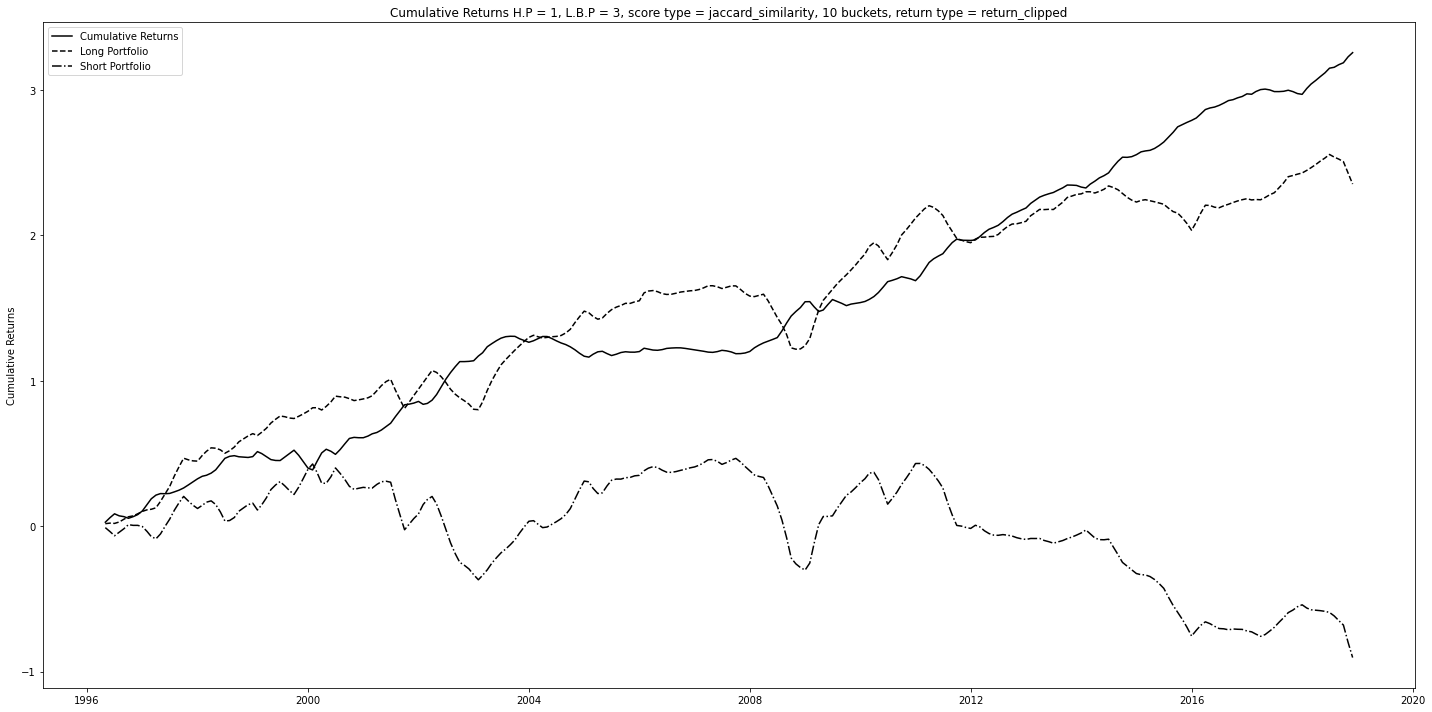

Value 
 
 
 
 
 Sharpe Ratio 
 1.99 
 
 
 Max Drawdown 
 -0.15 
 
 
 Hit Rate 
 73% 
 
 
 CAGR 
 15.42% 
 
 
 Monthly Returns 
 122bps 
 
 
 Monthly Vol 
 212bps

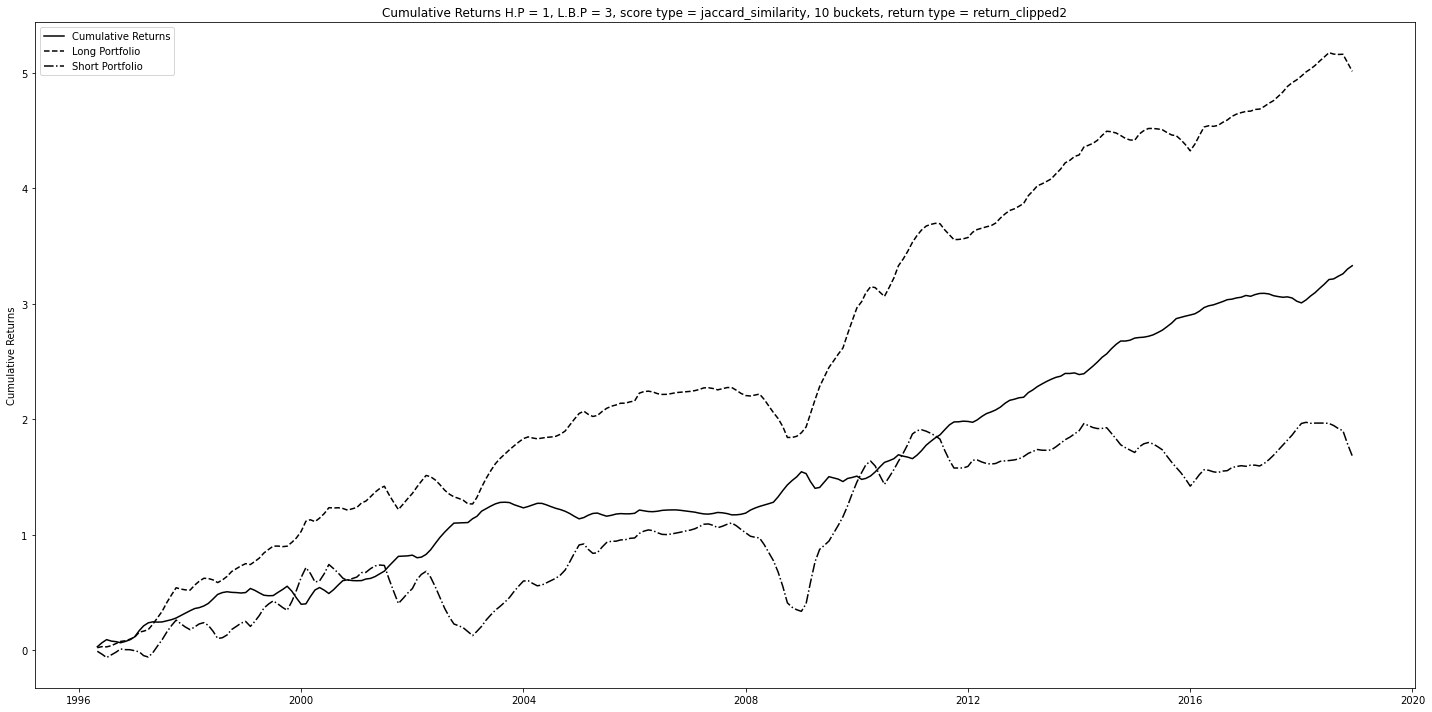

Value 
 
 
 
 
 Sharpe Ratio 
 3.8 
 
 
 Max Drawdown 
 -0.04 
 
 
 Hit Rate 
 84% 
 
 
 CAGR 
 13.82% 
 
 
 Monthly Returns 
 108bps 
 
 
 Monthly Vol 
 99bps

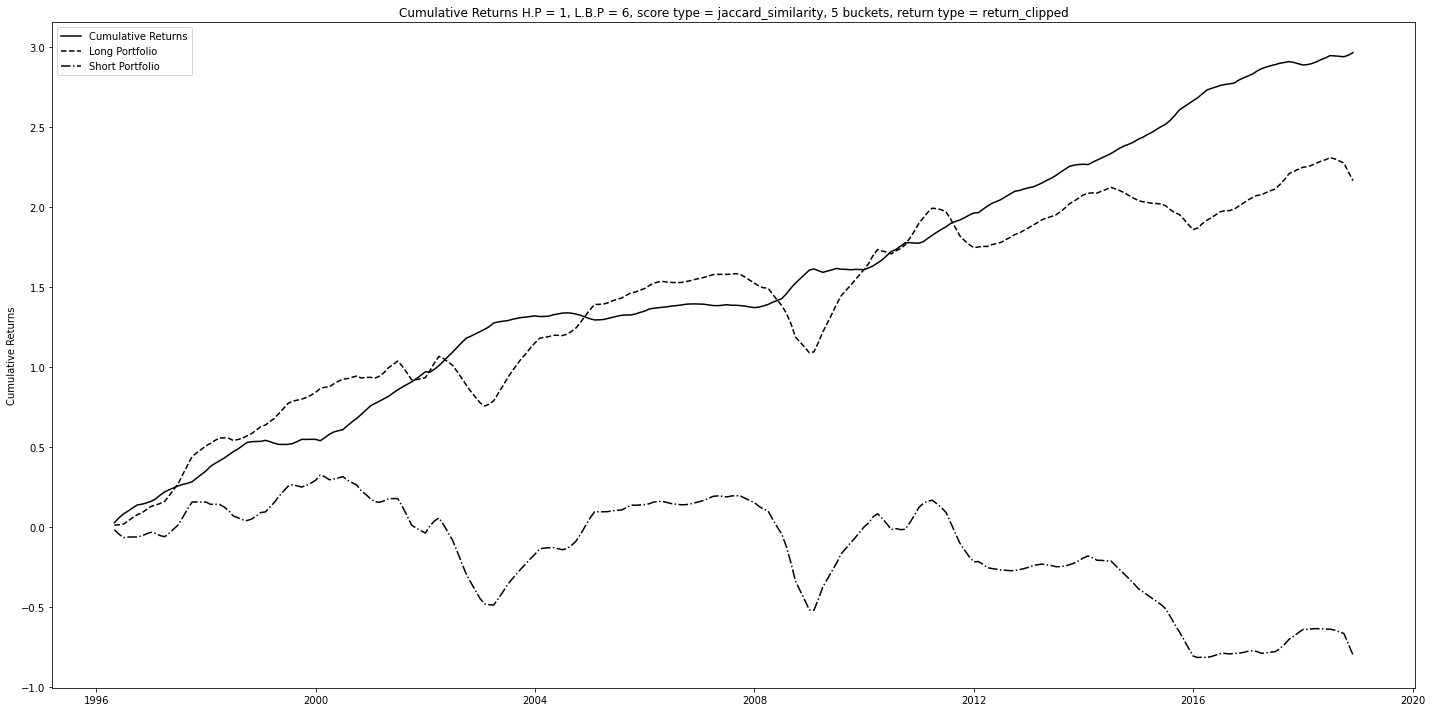

Value 
 
 
 
 
 Sharpe Ratio 
 3.37 
 
 
 Max Drawdown 
 -0.05 
 
 
 Hit Rate 
 84% 
 
 
 CAGR 
 13.52% 
 
 
 Monthly Returns 
 106bps 
 
 
 Monthly Vol 
 109bps

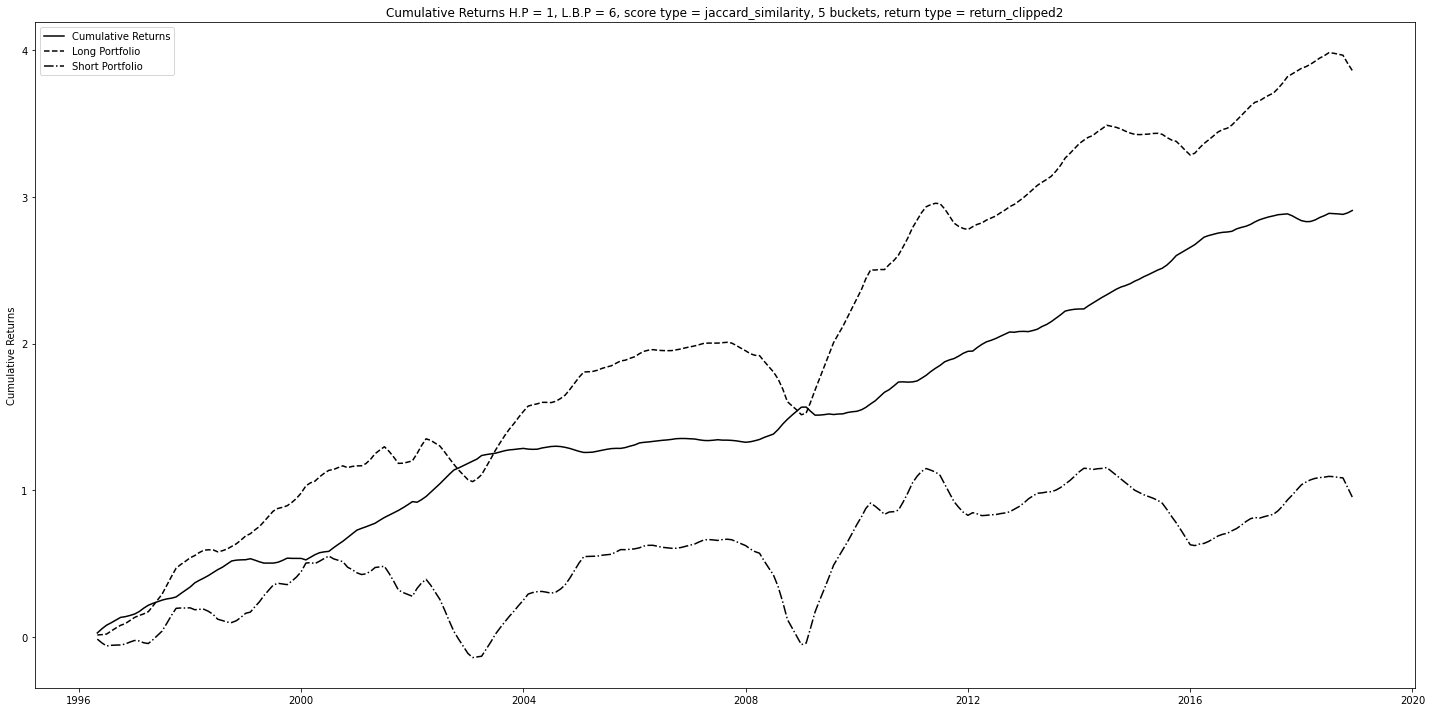

Value 
 
 
 
 
 Sharpe Ratio 
 2.99 
 
 
 Max Drawdown 
 -0.12 
 
 
 Hit Rate 
 78% 
 
 
 CAGR 
 14.19% 
 
 
 Monthly Returns 
 112bps 
 
 
 Monthly Vol 
 129bps

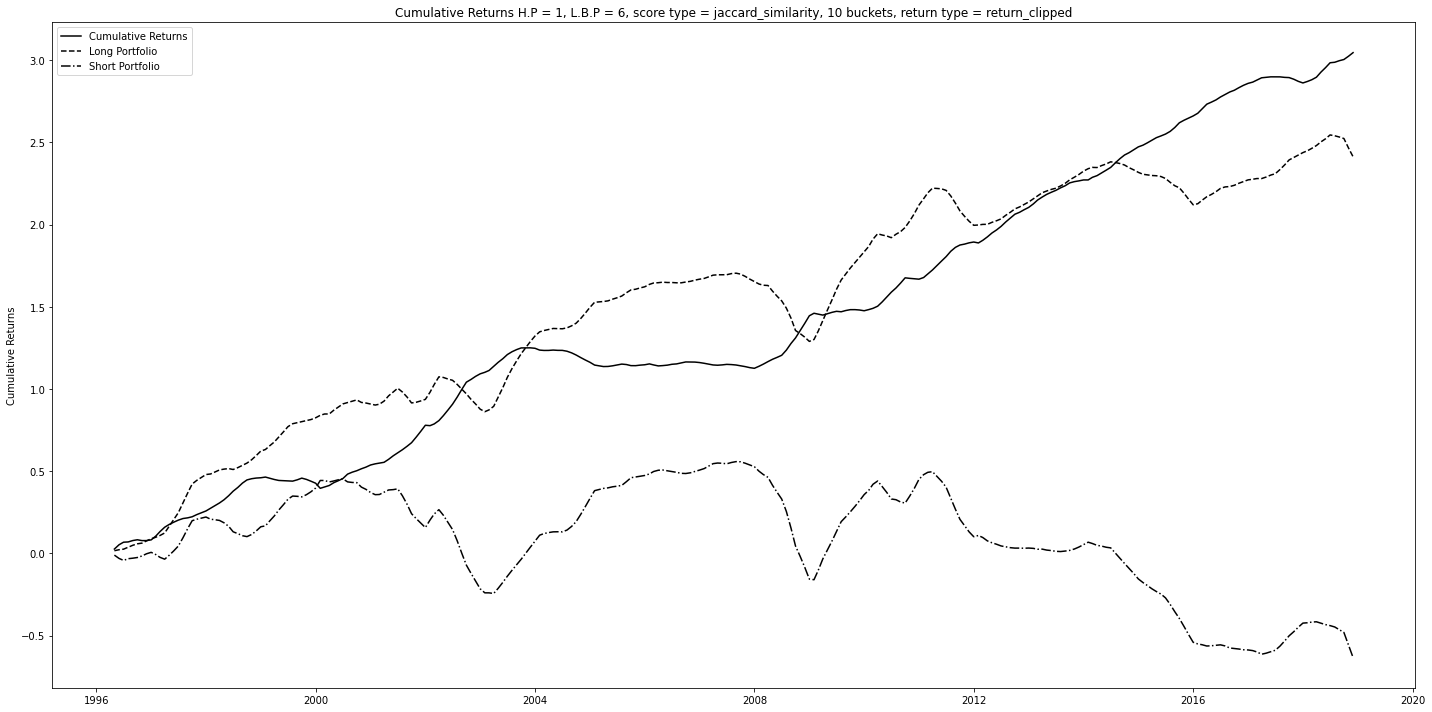

Value 
 
 
 
 
 Sharpe Ratio 
 2.85 
 
 
 Max Drawdown 
 -0.13 
 
 
 Hit Rate 
 77% 
 
 
 CAGR 
 15.15% 
 
 
 Monthly Returns 
 119bps 
 
 
 Monthly Vol 
 145bps

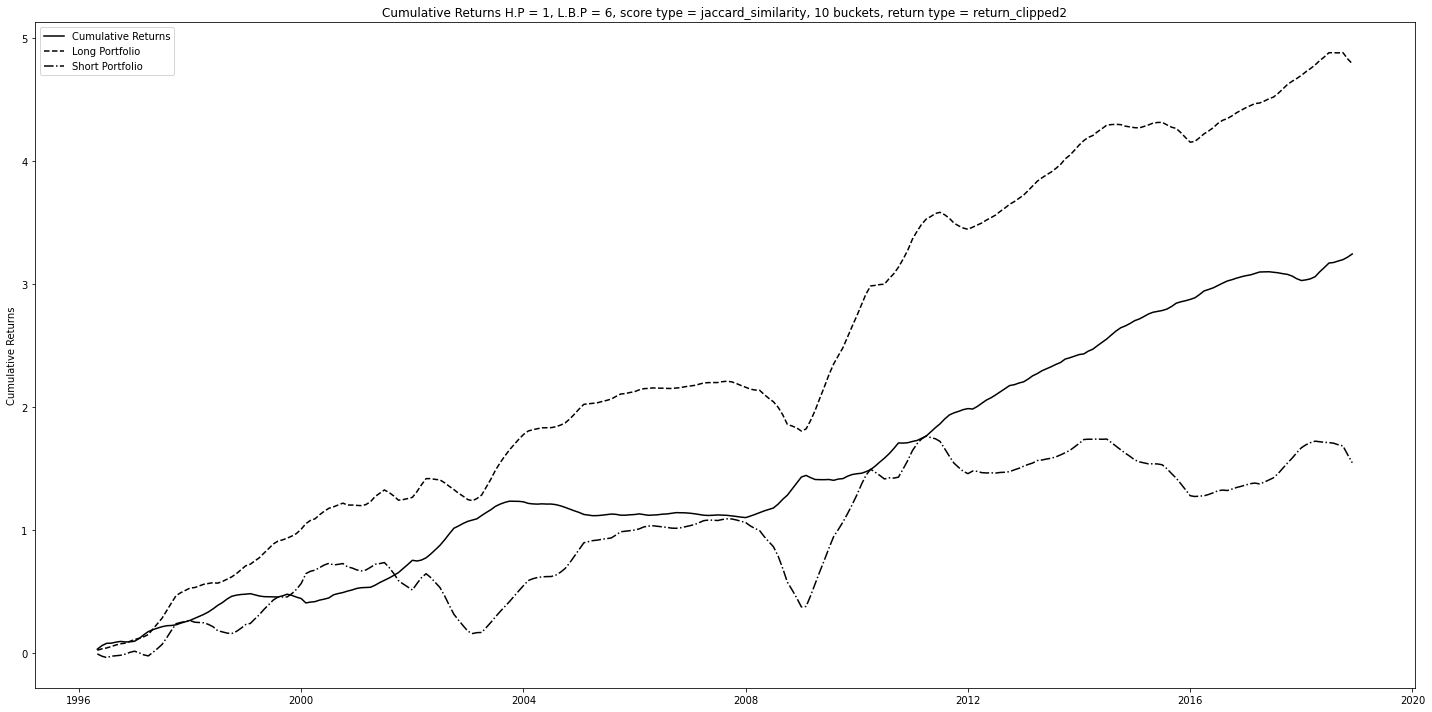

Value 
 
 
 
 
 Sharpe Ratio 
 2.34 
 
 
 Max Drawdown 
 -0.04 
 
 
 Hit Rate 
 91% 
 
 
 CAGR 
 10.96% 
 
 
 Monthly Returns 
 265bps 
 
 
 Monthly Vol 
 227bps

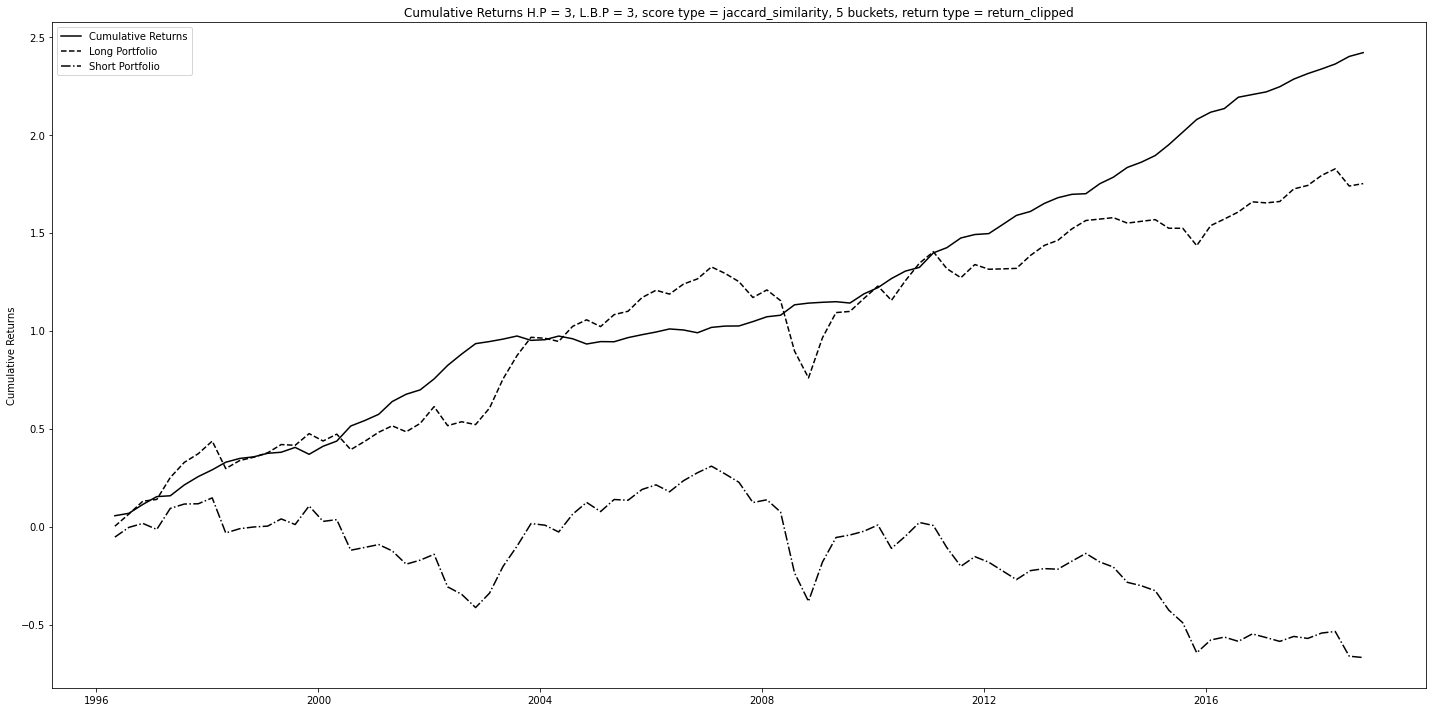

Value 
 
 
 
 
 Sharpe Ratio 
 1.72 
 
 
 Max Drawdown 
 -0.11 
 
 
 Hit Rate 
 84% 
 
 
 CAGR 
 11.66% 
 
 
 Monthly Returns 
 284bps 
 
 
 Monthly Vol 
 331bps

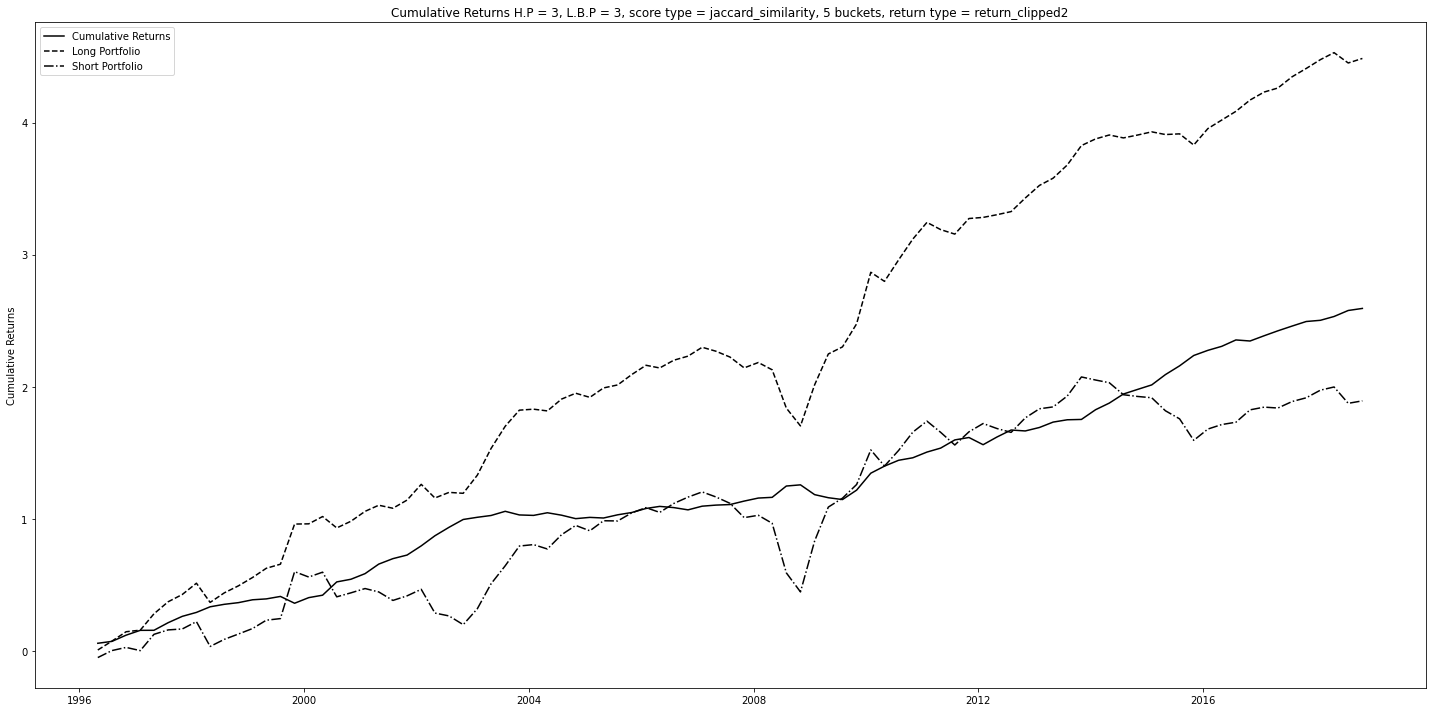

Value 
 
 
 
 
 Sharpe Ratio 
 2.19 
 
 
 Max Drawdown 
 -0.04 
 
 
 Hit Rate 
 86% 
 
 
 CAGR 
 12.13% 
 
 
 Monthly Returns 
 293bps 
 
 
 Monthly Vol 
 268bps

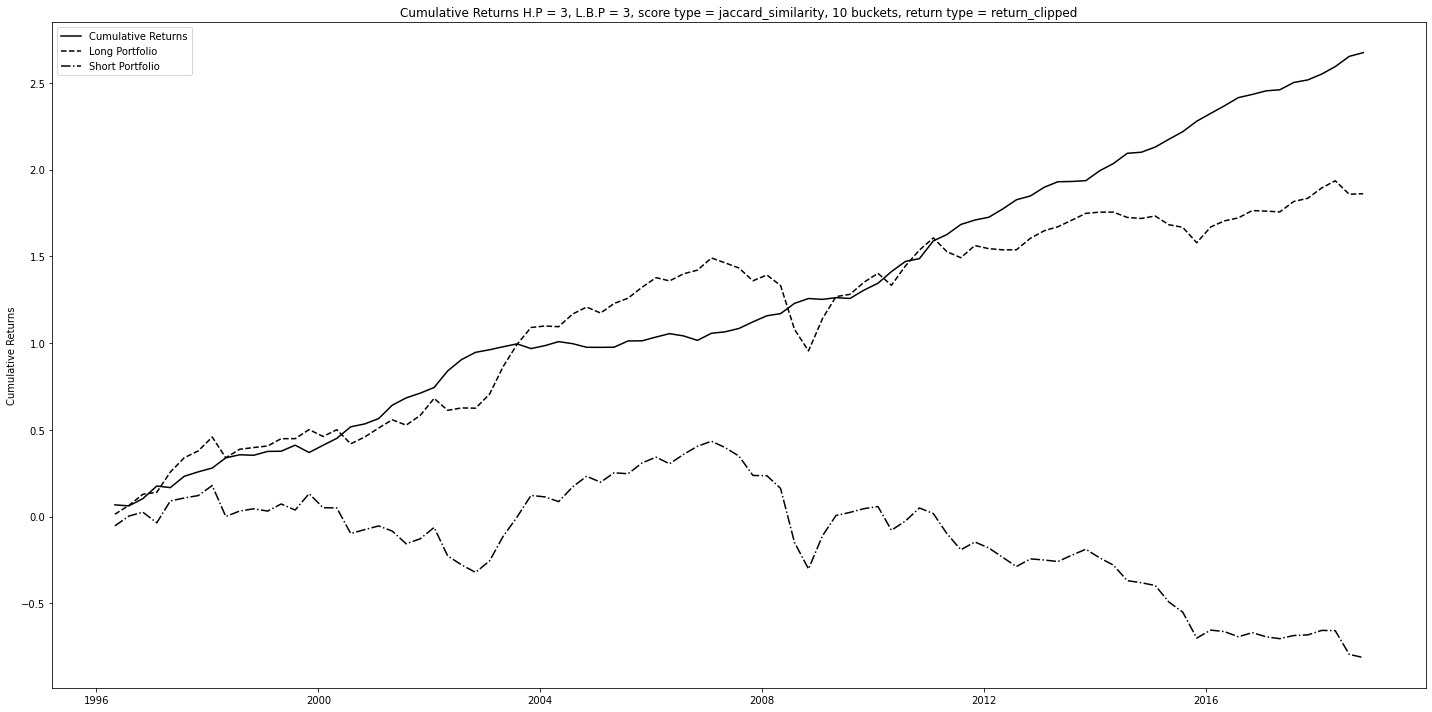

Value 
 
 
 
 
 Sharpe Ratio 
 1.49 
 
 
 Max Drawdown 
 -0.14 
 
 
 Hit Rate 
 83% 
 
 
 CAGR 
 16.72% 
 
 
 Monthly Returns 
 407bps 
 
 
 Monthly Vol 
 545bps

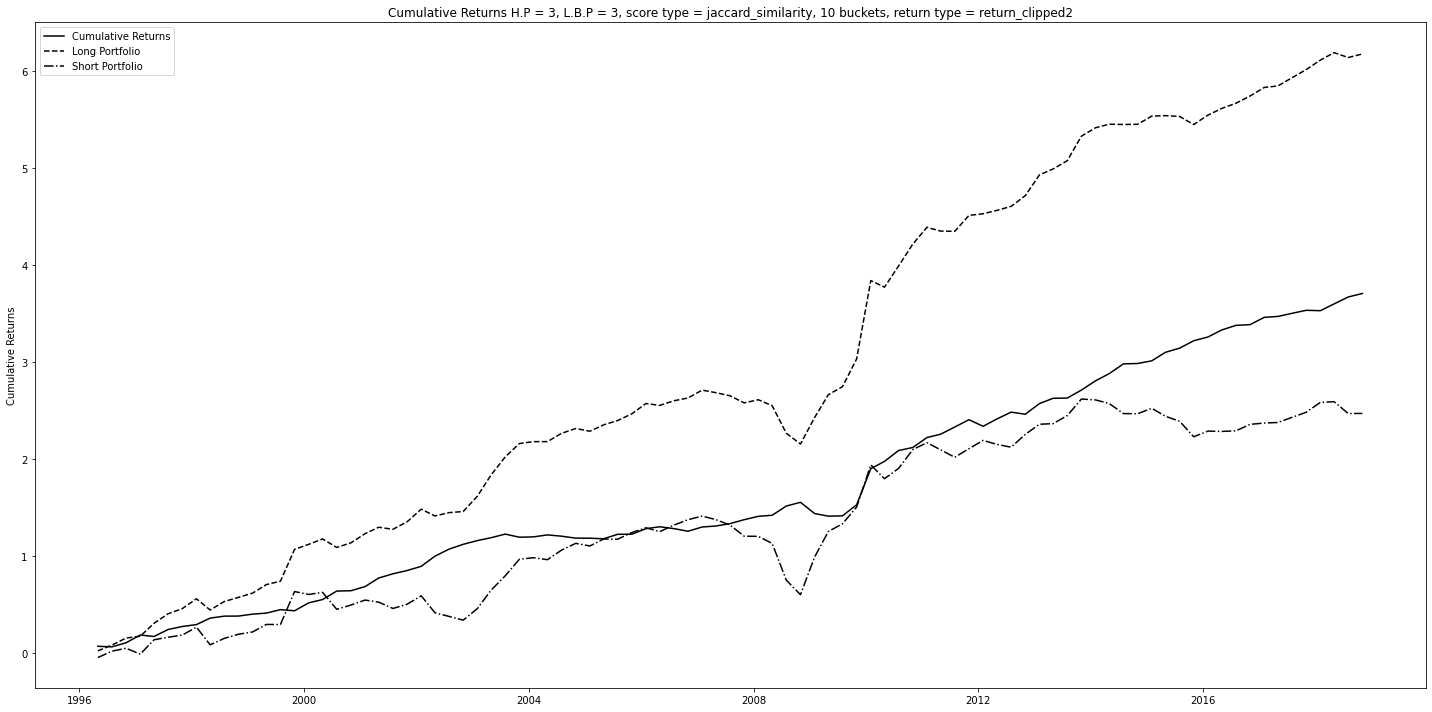

Value 
 
 
 
 
 Sharpe Ratio 
 2.53 
 
 
 Max Drawdown 
 -0.04 
 
 
 Hit Rate 
 89% 
 
 
 CAGR 
 10.07% 
 
 
 Monthly Returns 
 244bps 
 
 
 Monthly Vol 
 193bps

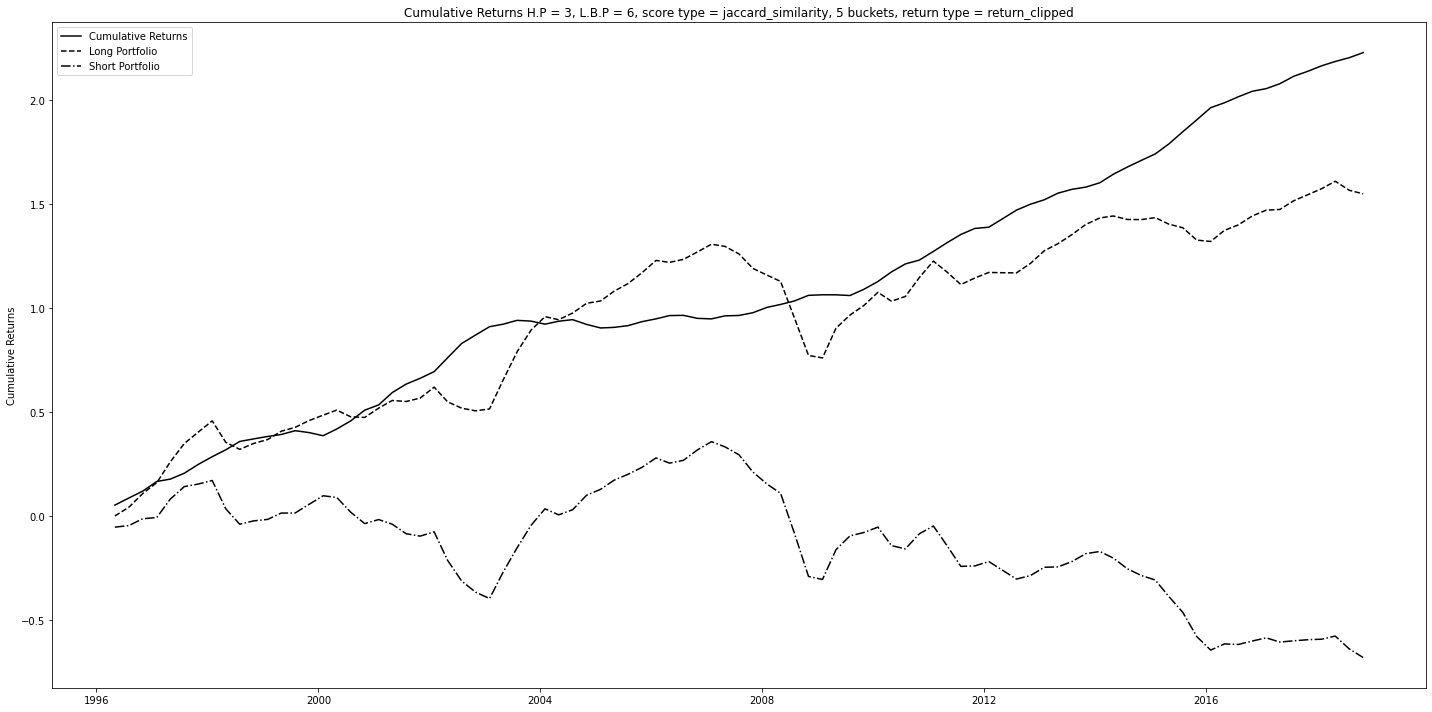

Value 
 
 
 
 
 Sharpe Ratio 
 2.12 
 
 
 Max Drawdown 
 -0.06 
 
 
 Hit Rate 
 84% 
 
 
 CAGR 
 11.15% 
 
 
 Monthly Returns 
 270bps 
 
 
 Monthly Vol 
 255bps

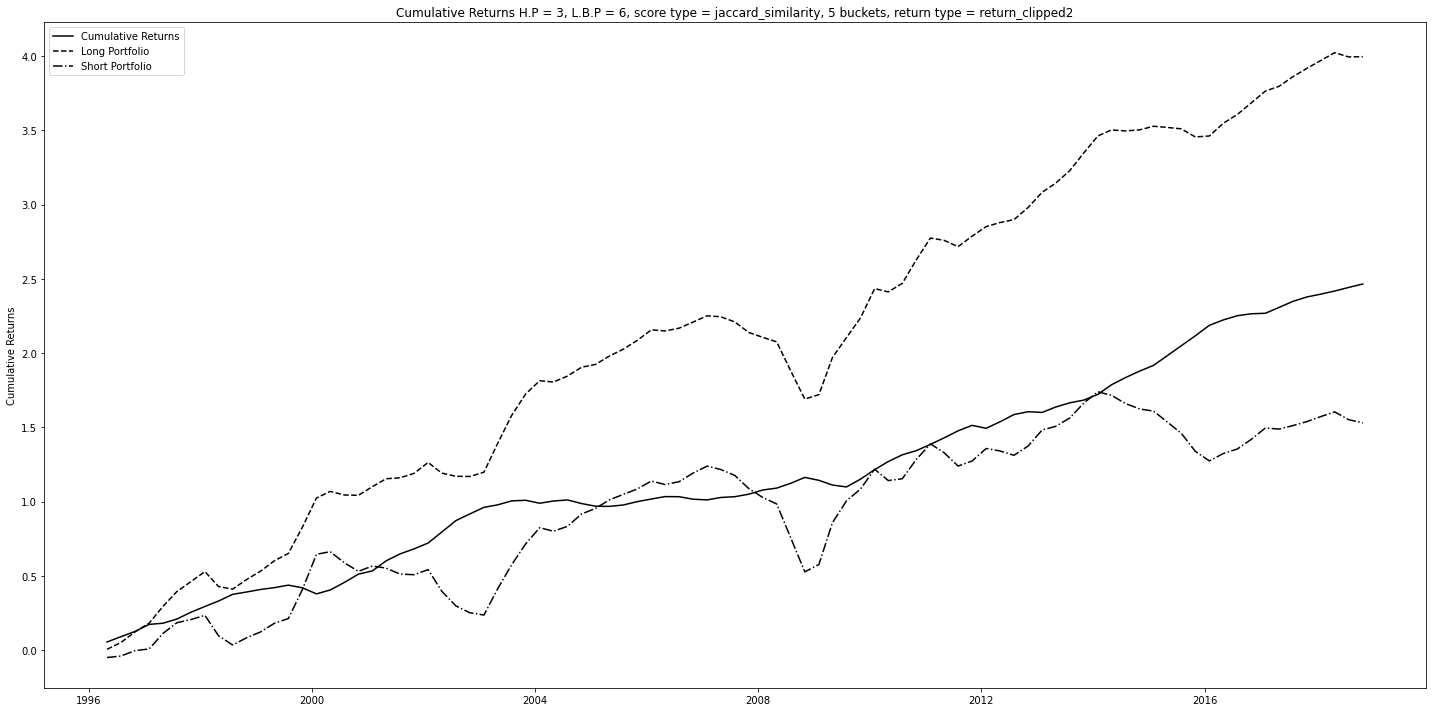

Value 
 
 
 
 
 Sharpe Ratio 
 2.51 
 
 
 Max Drawdown 
 -0.04 
 
 
 Hit Rate 
 90% 
 
 
 CAGR 
 11.53% 
 
 
 Monthly Returns 
 279bps 
 
 
 Monthly Vol 
 222bps

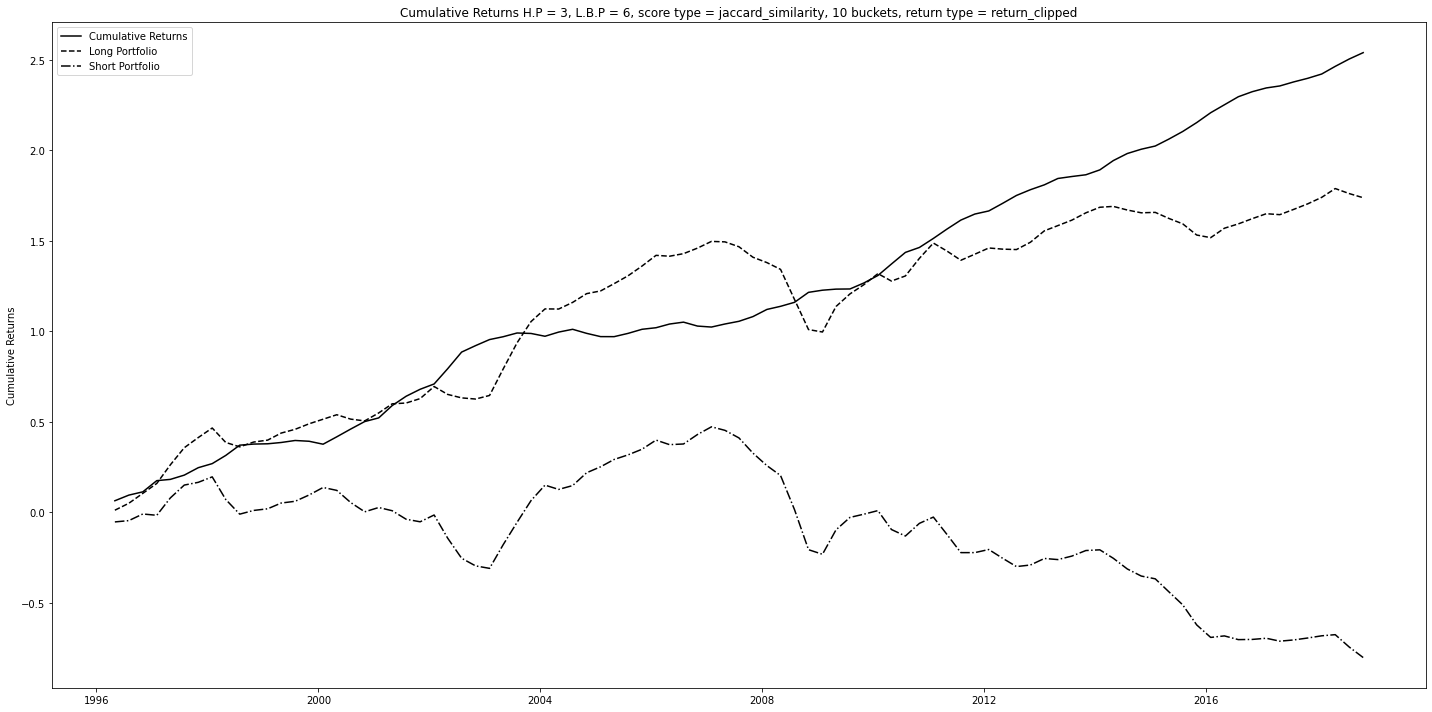

Value 
 
 
 
 
 Sharpe Ratio 
 2.3 
 
 
 Max Drawdown 
 -0.06 
 
 
 Hit Rate 
 89% 
 
 
 CAGR 
 15.72% 
 
 
 Monthly Returns 
 376bps 
 
 
 Monthly Vol 
 327bps

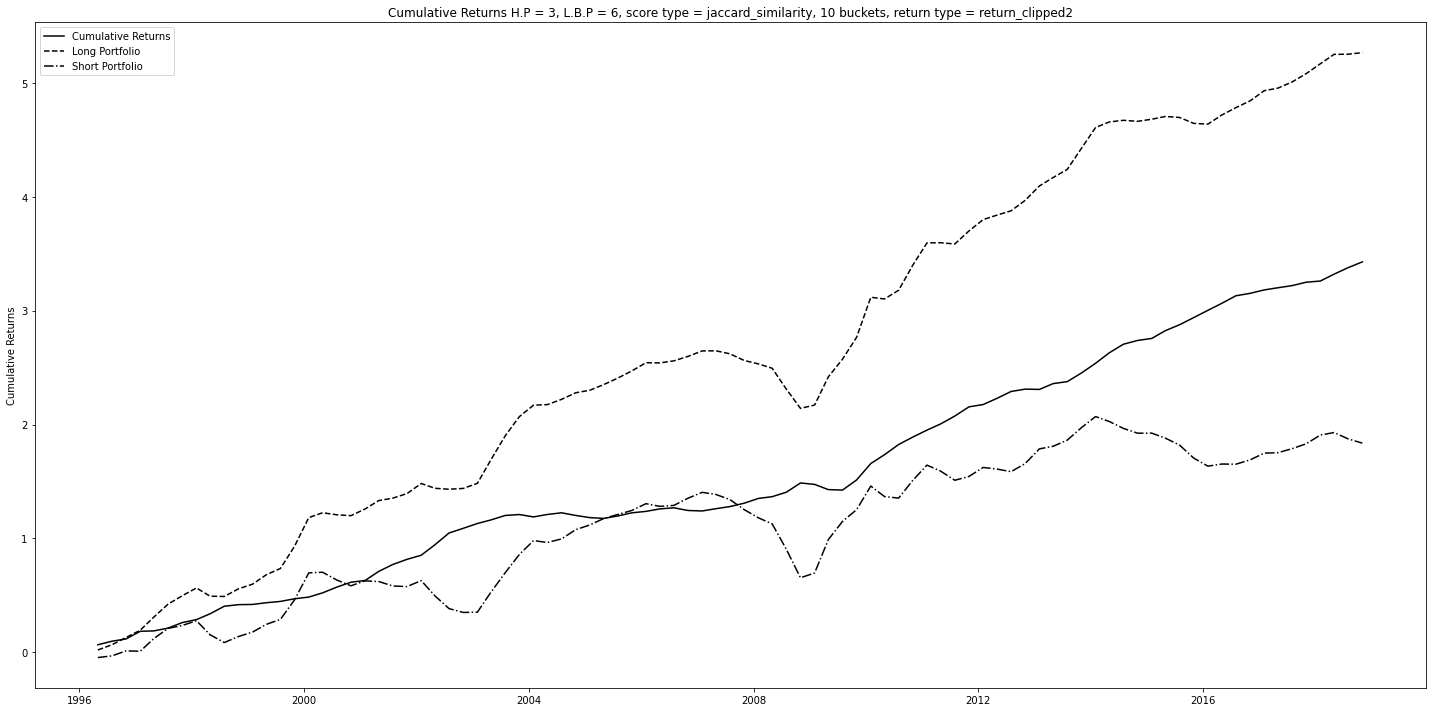

Value 
 
 
 
 
 Sharpe Ratio 
 2.04 
 
 
 Max Drawdown 
 -0.03 
 
 
 Hit Rate 
 93% 
 
 
 CAGR 
 7.72% 
 
 
 Monthly Returns 
 382bps 
 
 
 Monthly Vol 
 264bps

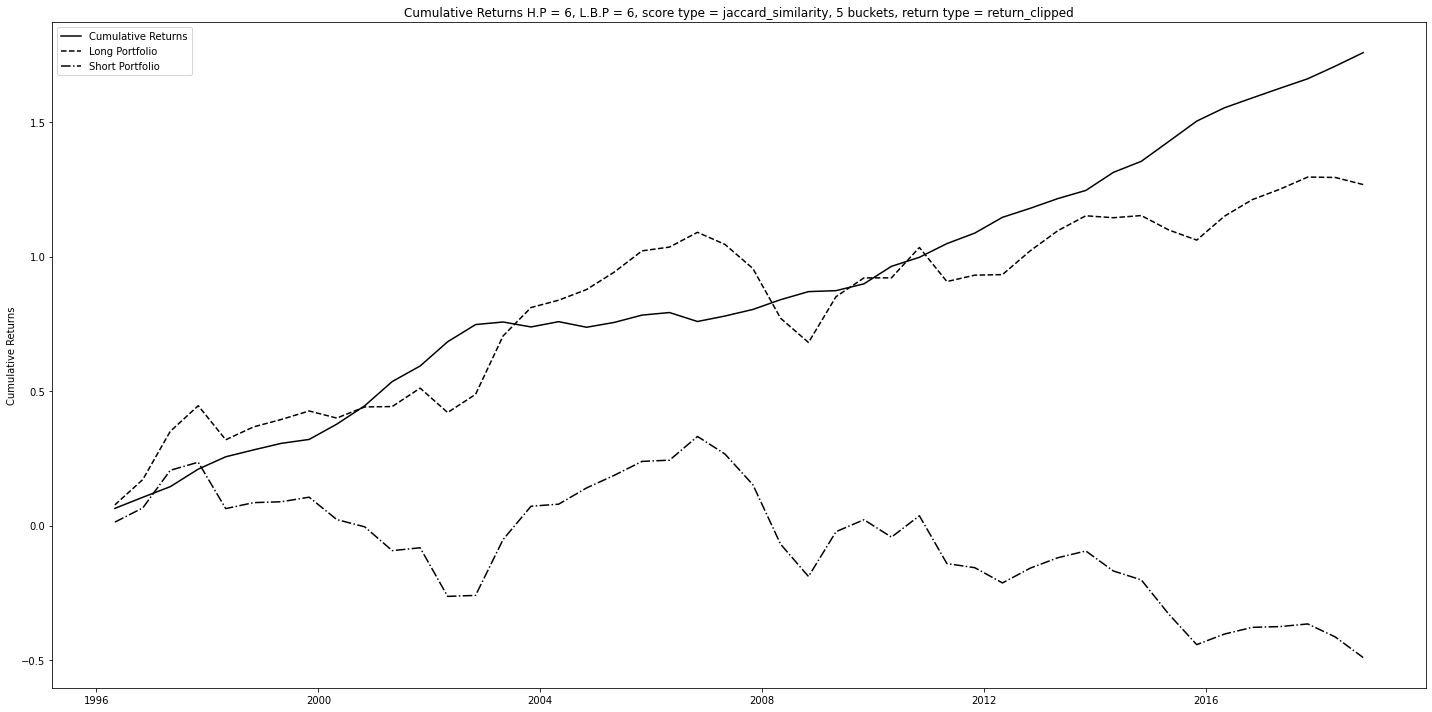

Value 
 
 
 
 
 Sharpe Ratio 
 1.88 
 
 
 Max Drawdown 
 -0.07 
 
 
 Hit Rate 
 91% 
 
 
 CAGR 
 10.84% 
 
 
 Monthly Returns 
 535bps 
 
 
 Monthly Vol 
 404bps

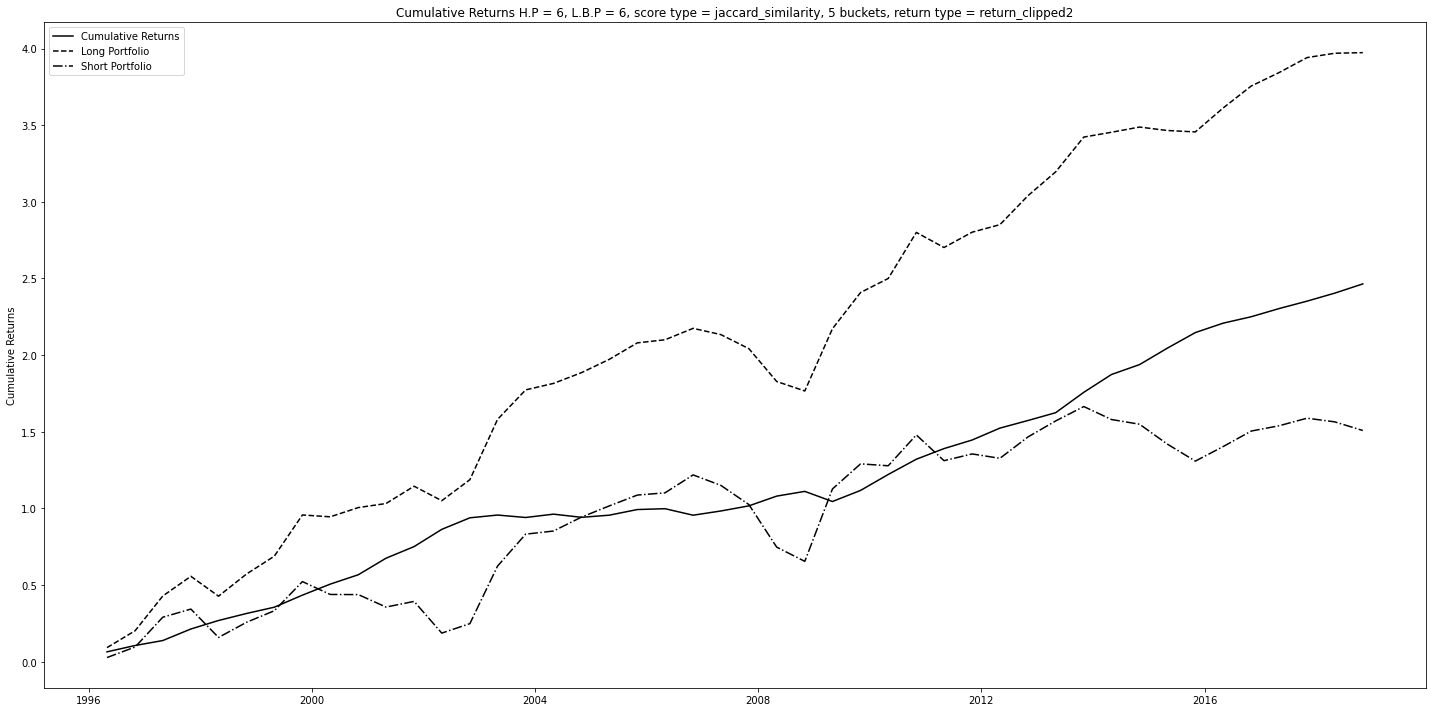

Value 
 
 
 
 
 Sharpe Ratio 
 2.01 
 
 
 Max Drawdown 
 -0.03 
 
 
 Hit Rate 
 93% 
 
 
 CAGR 
 9.09% 
 
 
 Monthly Returns 
 449bps 
 
 
 Monthly Vol 
 315bps

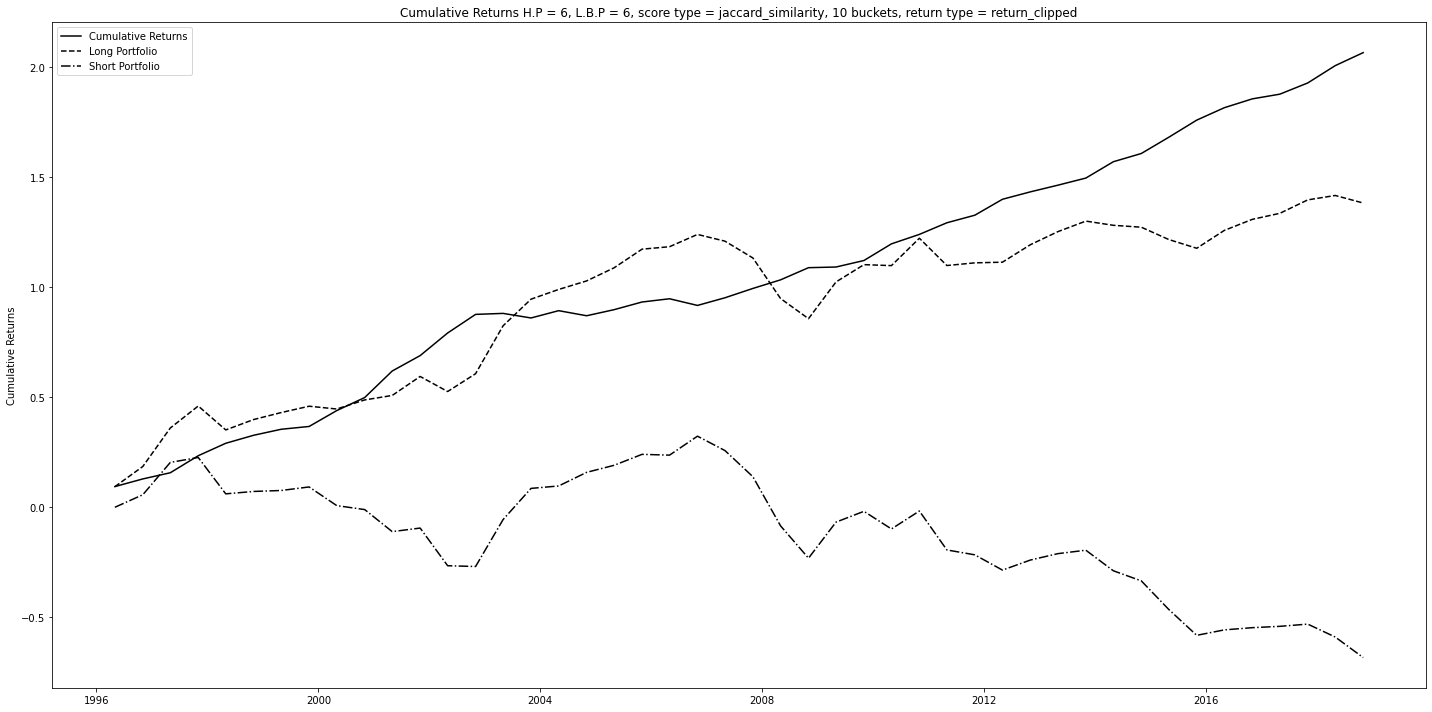

Value 
 
 
 
 
 Sharpe Ratio 
 1.56 
 
 
 Max Drawdown 
 -0.11 
 
 
 Hit Rate 
 91% 
 
 
 CAGR 
 16.52% 
 
 
 Monthly Returns 
 818bps 
 
 
 Monthly Vol 
 743bps

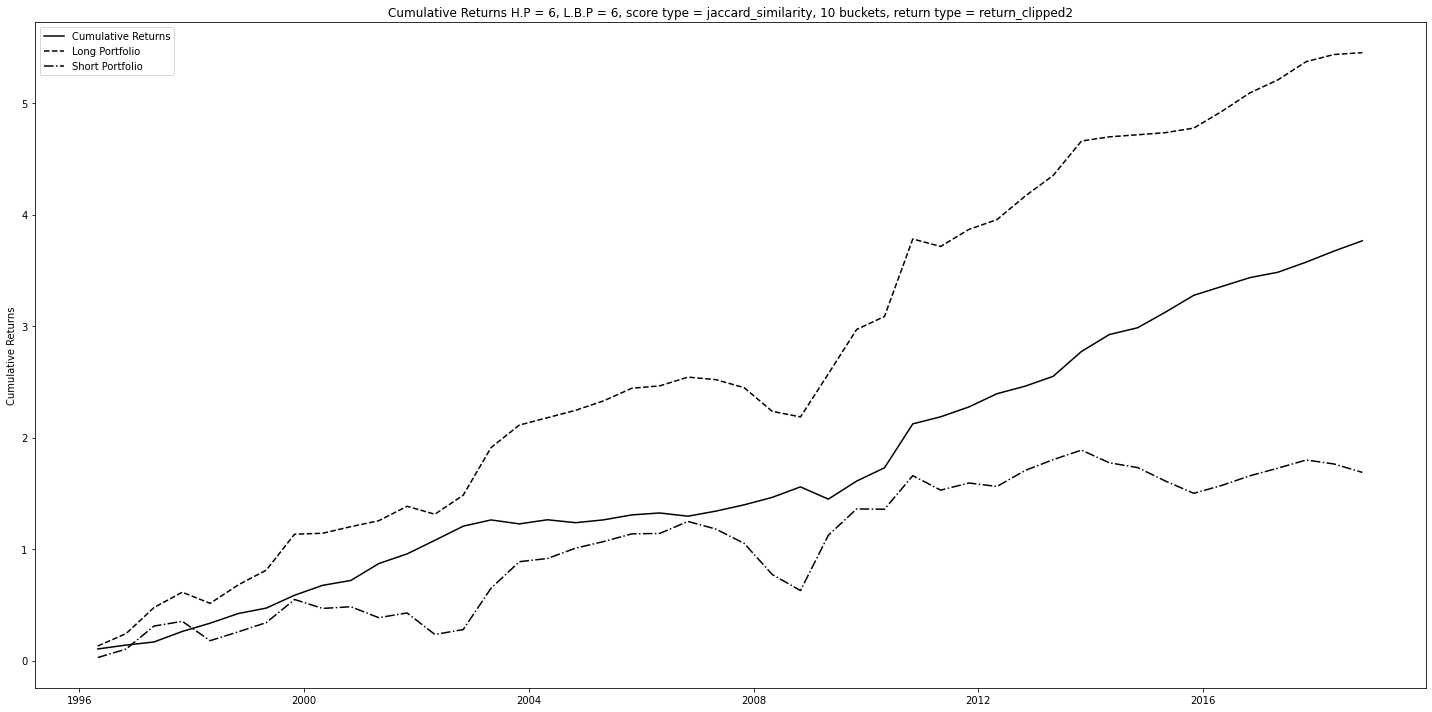

In [13]:
for score_type in ['cosine_similarity', 'jaccard_similarity']:
    for hold_period in [1,3,6]:
        for history in [1,3,6]:
            if history < hold_period:
                    continue
            for num_bucket in [5, 10]:
                file_path_req = f'{folder_path}/F_and_H/f{hold_period}_and_h{history}/n_{num_bucket}/{score_type}/ret.parquet'
                portfolio = pq.read_table(file_path_req).to_pandas()
                #portfolio = get_monthly_returns(portfolio, hold_period)
                print(f"Running for hold_period: {hold_period}, lookback_period: {history}, num_bucket: {num_bucket}, score_type: {score_type}")
                title = f'H.P = {hold_period}, L.B.P = {history}, score type = {score_type}, {num_bucket} buckets, '
                for return_type in ['return_clipped', 'return_clipped2']:
                    title_req = title + f'return type = {return_type}'
                    display(compute_portfolio_metrics(portfolio[return_type], hold_period))
                    plot_long_short_cumm_returns(portfolio['long_' + return_type], portfolio['short_' + return_type], portfolio['date'], title=title_req)
                

In [15]:
factor_returns = pd.read_csv('/data/workspace_files/F-F_Research_Data_5_Factors_2x3.csv')
factor_returns.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
factor_returns['Date'] = pd.to_datetime(factor_returns['Date'], format='%Y%m',errors='coerce')
factor_returns.dropna(subset=['Date'],inplace=True)

In [17]:
import statsmodels.api as sm

def compute_alpha(score_type, factors, factor_returns, model_name):
    alpha = {}
    for quintile in range(1, 6):
        # Load portfolio returns for each quintile
        port_returns = pq.read_table(f'/data/workspace_files/parquet_files/portfolio_returns/1996_2014/{score_type}_Q{quintile}_sp500.parquet').to_pandas()
        port_returns.rename(columns={'date': 'Date'}, inplace=True)

        # Merge portfolio returns with factor returns on 'Date'
        merged = pd.merge(port_returns, factor_returns, on='Date')
        merged['Mkt-RF'] = merged['Mkt-RF'].astype(float)
        merged['SMB'] = merged['SMB'].astype(float)
        merged['HML'] = merged['HML'].astype(float)
        merged['RMW'] = merged['RMW'].astype(float)
        merged['CMA'] = merged['CMA'].astype(float)
        merged['return_clipped2'] = merged['return_clipped2'].astype(float)
        merged['RF'] = merged['RF'].astype(float)
        y = merged['return_clipped2']
        x = merged[factors]
        x = sm.add_constant(x)  # Add a constant term for the intercept

        # Fit the OLS model and extract the alpha value
        model = sm.OLS(y, x).fit()
        alpha[f'Q{quintile}_alpha'] = model.params['const']  # Access the intercept term
        alpha[f'Q{quintile}_tstat'] = model.tvalues['const']
        alpha['model'] = model_name

    port_returns = pq.read_table(f'/data/workspace_files/parquet_files/portfolio_returns/1996_2014/{score_type}_LS_sp500.parquet').to_pandas()
    port_returns.rename(columns={'date': 'Date'}, inplace=True)

    # Merge portfolio returns with factor returns on 'Date'
    merged = pd.merge(port_returns, factor_returns, on='Date')
    merged['Mkt-RF'] = merged['Mkt-RF'].astype(float)
    merged['SMB'] = merged['SMB'].astype(float)
    merged['HML'] = merged['HML'].astype(float)
    merged['RMW'] = merged['RMW'].astype(float)
    merged['CMA'] = merged['CMA'].astype(float)
    merged['return_clipped2'] = merged['return_clipped2'].astype(float)
    merged['RF'] = merged['RF'].astype(float)
    y = merged['return_clipped2']
    x = merged[factors]
    x = sm.add_constant(x)  # Add a constant term for the intercept

    # Fit the OLS model and extract the alpha value
    model = sm.OLS(y, x).fit()
    alpha[f'LS_alpha'] = model.params['const']  # Access the intercept term
    alpha[f'LS_tstat'] = model.tvalues['const']
    alpha['model'] = model_name

    return alpha

for score_type in ['cosine_similarity', 'jaccard_similarity']:
    excess_return = compute_alpha(score_type, ['Mkt-RF'], factor_returns, 'Excess Return')
    three_factor = compute_alpha(score_type, ['Mkt-RF', 'SMB', 'HML'], factor_returns, '3 Factor Model')
    five_factor = compute_alpha(score_type,['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], factor_returns, '5 Factor Model')
    alpha_arr = [excess_return, three_factor, five_factor]
    df = pd.DataFrame(alpha_arr)
    df = df[['model', 'LS_alpha', 'LS_tstat', 'Q1_alpha', 'Q1_tstat', 'Q2_alpha', 'Q2_tstat', 'Q3_alpha', 'Q3_tstat', 'Q4_alpha', 'Q4_tstat', 'Q5_alpha', 'Q5_tstat']]

    display(df.round(2))

model 
 LS_alpha 
 LS_tstat 
 Q1_alpha 
 Q1_tstat 
 Q2_alpha 
 Q2_tstat 
 Q3_alpha 
 Q3_tstat 
 Q4_alpha 
 Q4_tstat 
 Q5_alpha 
 Q5_tstat 
 
 
 
 
 0 
 Excess Return 
 0.51 
 4.84 
 0.54 
 2.74 
 0.87 
 4.26 
 0.68 
 3.23 
 0.56 
 2.70 
 1.02 
 4.99 
 
 
 1 
 3 Factor Model 
 0.51 
 4.93 
 0.51 
 2.59 
 0.83 
 4.11 
 0.62 
 3.02 
 0.51 
 2.51 
 0.98 
 4.84 
 
 
 2 
 5 Factor Model 
 0.52 
 4.81 
 0.53 
 2.58 
 0.82 
 3.94 
 0.57 
 2.69 
 0.47 
 2.24 
 1.03 
 4.88

model 
 LS_alpha 
 LS_tstat 
 Q1_alpha 
 Q1_tstat 
 Q2_alpha 
 Q2_tstat 
 Q3_alpha 
 Q3_tstat 
 Q4_alpha 
 Q4_tstat 
 Q5_alpha 
 Q5_tstat 
 
 
 
 
 0 
 Excess Return 
 0.42 
 3.44 
 0.53 
 2.64 
 0.80 
 3.76 
 0.60 
 2.96 
 0.76 
 3.71 
 0.96 
 4.72 
 
 
 1 
 3 Factor Model 
 0.43 
 3.53 
 0.49 
 2.45 
 0.76 
 3.60 
 0.55 
 2.78 
 0.72 
 3.54 
 0.91 
 4.57 
 
 
 2 
 5 Factor Model 
 0.40 
 3.17 
 0.49 
 2.36 
 0.76 
 3.45 
 0.52 
 2.55 
 0.74 
 3.50 
 0.90 
 4.35

In [ ]:
def plot_spy_returns(ret1, ret2, spy_ret_cum, dates, title = None):
    ret1 = ret1/100
    ret2 = ret2/100

    #long_cum_ret = (1 + long_ret).cumprod() - 1
    #short_cum_ret = (1 + short_ret).cumprod() - 1
    ret1 = ret1.cumsum()
    ret2 = ret2.cumsum()
    #port_ret2 = long_cum_ret - short_cum_ret

    #Plot cumulative returns
    plt.figure(figsize=(20, 10))
    #plt.plot(dates, port_ret2, color='green', linestyle = ':', label='Cumulative Returns1')
    plt.plot(dates, ret1, linestyle = '-', label = 'Jaccard Similarity')
    plt.plot(dates, ret2, linestyle = '-', label = 'Cosine Similarity')
    #plt.plot(dates, long_cum_ret, color = 'black', linestyle = 'dashed', label = 'Long Portfolio')
    #plt.plot(dates, short_cum_ret, color = 'black', linestyle = '-.', label = 'Short Portfolio')
    plt.plot(dates, spy_ret_cum, color = 'blue', linestyle = '-.', label = 'SPY')
    plt.ylabel('Cumulative Returns', fontsize=16)

    plt.title(f'{title}',fontsize=18)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)  # Adjust the font size as needed
    plt.yticks(fontsize=16)  # Adjust the font size as needed

    plt.show()
    
def get_SPY_returns(start, end):
    end = end + relativedelta(months=1)
    SP500 = yf.download('^GSPC', start=start, end=end)['Adj Close']
    monthly_prices = SP500.resample('M').agg(['first', 'last']).reset_index()
    monthly_prices['Return'] = (monthly_prices['last'] / monthly_prices['first'] - 1)
    monthly_prices['Cumm_Return'] = monthly_prices['Return'].cumsum()
    return monthly_prices


file_path_req = f'/data/workspace_files/parquet_files/portfolio_returns/1996_2014/cosine_similarity_LS_sp500.parquet'
cos_sim = pq.read_table(file_path_req).to_pandas()
file_path_req = f'/data/workspace_files/parquet_files/portfolio_returns/1996_2014/jaccard_similarity_LS_sp500.parquet'
jac_sim = pq.read_table(file_path_req).to_pandas()

dates = cos_sim['date']
spy_ret = get_SPY_returns(dates.iloc[0], dates.iloc[-1])
title = f'Performance of LS strategy on S&P500 stocks'
plot_long_short_cumm_returns(jac_sim['return_clipped2'], cos_sim['return_clipped2'], spy_ret['Cumm_Return'], dates, title = title)
    